In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn import preprocessing
from theano import shared
from matplotlib.offsetbox import AnchoredText

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.8.2
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 9 Markov Chain Monte Carlo

## 9.1. Good King Markov and His island kingdom

### Code 9.1

In [4]:
# parameters
num_weeks = 100000
positions = np.zeros(num_weeks, dtype=int)
current = 10
# King Markov’s journey
for i in range(num_weeks):
    # record current position
    positions[i] = current
    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # now make sure he loops around the archipelago
    if proposal < 1:
        proposal = 10
    if  proposal > 10:
        proposal = 1
    # move?
    prob_move = proposal/current
    if np.random.uniform() < prob_move:
        current = proposal

### Code 9.2 and Code 9.3

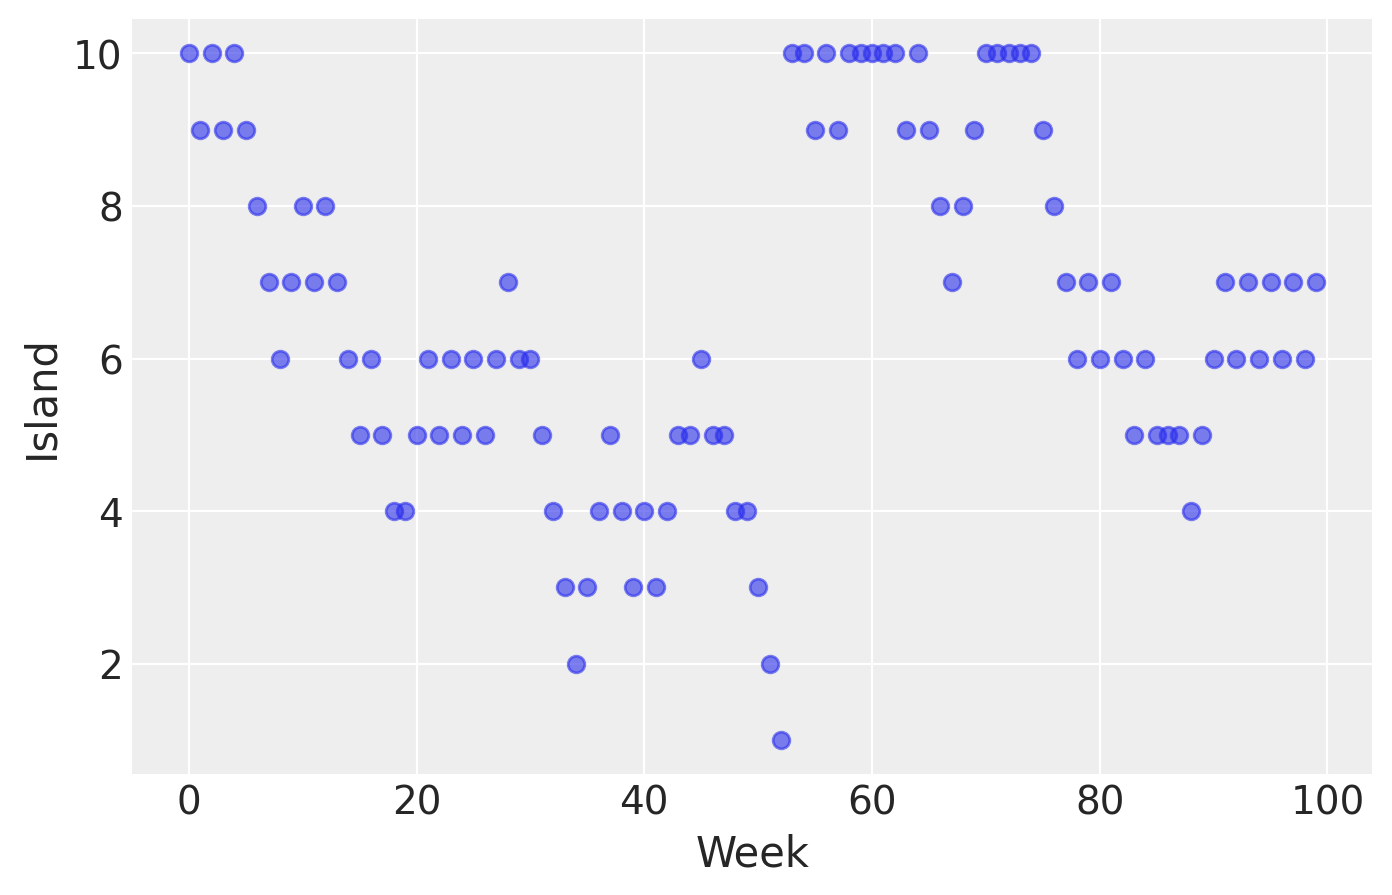

In [5]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.scatter(np.arange(100), positions[:100], alpha=0.6)
plt.ylabel('Island', fontsize=15)
plt.xlabel('Week', fontsize=15)
plt.show()

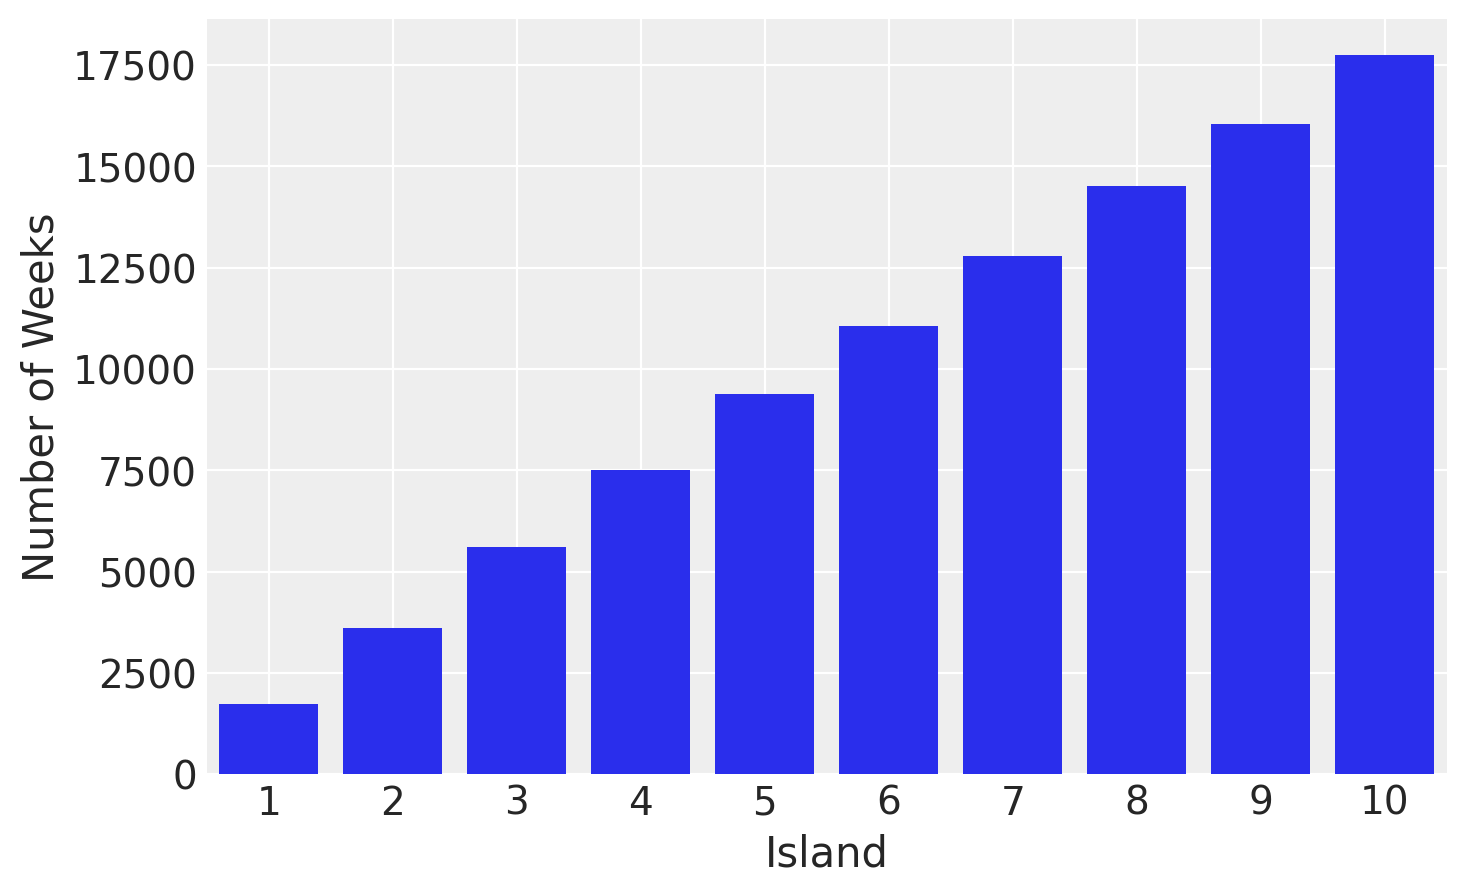

In [6]:
# plot results
fig = plt.figure(figsize=(8, 5))
# plt.hist(positions, bins = 10, histtype='bar', stacked=True)
plt.bar(np.arange(11), np.bincount(positions))
plt.xticks(np.arange(11))
plt.xlim([0.5,10.5])
plt.ylabel('Number of Weeks', fontsize=15)
plt.xlabel('Island', fontsize=15)
plt.show()

## 9.2. Metropolis Algorithms

### 9.2.1. Gibbs sampling

**Gibbs sampling** is a variant of the Metropolis-Hastings algorithm that uses clever proposals and is therefore more efficient. By “efficient,” I mean that you can get a good estimate of the posterior from Gibbs sampling with many fewer samples than a comparable Metropolis approach. The improvement arises from adaptive proposals in which the distribu- tion of proposed parameter values adjusts itself intelligently, depending upon the parameter values at the moment.

### 9.2.2. High-dimensional problems

In [7]:
D = 10
T = 1000
Y = stats.multivariate_normal.rvs(np.zeros(D), np.identity(D), T)

In [8]:
def rad_dist(Y):
    return np.sqrt(sum(Y**2))

In [9]:
Rd = np.zeros(T)
for i in range(T):
    Rd[i] = rad_dist(Y[i,:])

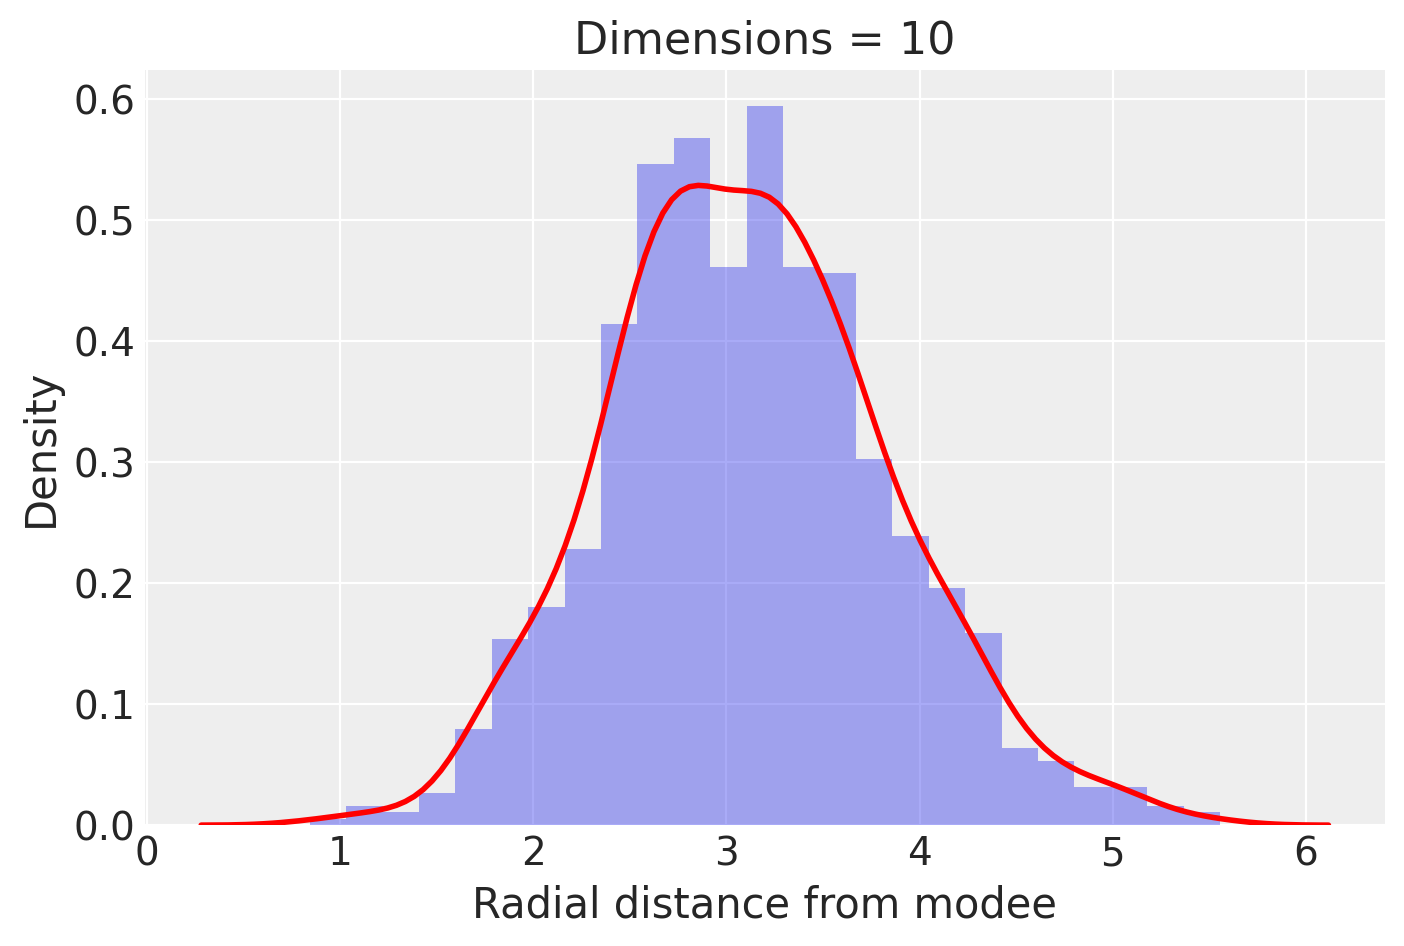

In [10]:
# plot figure
fig = plt.figure(figsize=(8, 5))
sns.distplot(Rd, hist = True, kde = True, kde_kws = {'linewidth': 2, 'color': 'r'})
plt.xlabel('Radial distance from modee', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title('Dimensions = {:d}'.format(D))
plt.show()

## 9.3. Hamiltonian Monte Carlo

**Hamiltonian Monte Carlo** (or Hybrid Monte Carlo, HMC) pushes Jaynes’ principle much further. HMC is more computationally costly than Metropolis or Gibbs sampling. But its proposals are also much more efficient.

### 9.3.1. Another parable

The autocorrelation between locations visited is very low under this strategy. This means that adjacent locations have a very low, almost zero correlation. 

### 9.3.2. Particles in space

### 9.3.3. Limitations

## 9.4. Easy HMC: ulam

### Code 9.11

In [11]:
# load cars data
df = pd.read_csv("Data/rugged.csv", sep=";", header=0)

# make log version of outcome
df['log_gdp'] = np.log(df['rgdppc_2000'])

# extract countries with GDP data
d2f = df.dropna(axis=0, subset=['rgdppc_2000']).copy()

# rescale variables
d2f['log_gdp_std'] = d2f['log_gdp']/d2f['log_gdp'].mean()
d2f['rugged_std'] = d2f['rugged']/d2f['rugged'].max()

# set index variable
d2f['africa_id'] = pd.Categorical(d2f['cont_africa']).codes

d2f.head()

isocode  isonum               country  rugged  rugged_popw  rugged_slope  \
2     AGO      24                Angola   0.858        0.714         2.274   
4     ALB       8               Albania   3.427        1.597        10.451   
7     ARE     784  United Arab Emirates   0.769        0.316         2.112   
8     ARG      32             Argentina   0.775        0.220         2.268   
9     ARM      51               Armenia   2.688        0.934         8.178   

   rugged_lsd  rugged_pc  land_area     lat  ...  dist_slavemkt_atlantic  \
2       0.228      4.906   124670.0 -12.299  ...                   5.669   
4       1.006     62.133     2740.0  41.143  ...                     NaN   
7       0.191      6.142     8360.0  23.913  ...                     NaN   
8       0.226      9.407   273669.0 -35.396  ...                     NaN   
9       0.799     50.556     2820.0  40.294  ...                     NaN   

   dist_slavemkt_indian  dist_slavemkt_saharan  dist_slavemkt_redsea  \
2                 6.981                  4.926                 3.872   
4                   NaN                    NaN                   NaN   
7                   NaN                    NaN                   NaN   
8                   NaN                    NaN                   NaN   
9                   NaN                    NaN                   NaN   

    pop_1400  european_descent   log_gdp  log_gdp_std  rugged_std  africa_id  
2  1223208.0             2.000  7.492609     0.879712    0.138342          1  
4   200000.0           100.000  8.216929     0.964755    0.552564          0  
7    19200.0             0.000  9.933263     1.166270    0.123992          0  
8   276632.0            89.889  9.407032     1.104485    0.124960          0  
9   105743.0             0.500  7.792343     0.914904    0.433409          0  

[5 rows x 55 columns]

### Code 9.12

In [12]:
mean_rugged_std = d2f['rugged_std'].mean()
# define model: log_GDP ~ rugged (slope condition)
with pm.Model() as m8_3:
    a = pm.Normal('a', mu=1, sd=0.1, shape=d2f['africa_id'].max()+1)
    b = pm.Normal('b', mu=0, sd=0.3, shape=d2f['africa_id'].max()+1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a[d2f['africa_id'].values]+b[d2f['africa_id'].values]*(d2f['rugged_std']-mean_rugged_std))
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=d2f['log_gdp_std'])
    m8_3_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3258.20draws/s]


### 9.4.1. Preparation

### Code 9.13

None needs to done in Python

### 9.4.2. Sampling from the posterior

### Code 9.14

None needs to done in Python

### Code 9.15

In [13]:
# show model summary
varnames = ['~mu']
az.summary(m8_3_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/arviz/utils.py:653: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


mean    sd  hdi_3%  hdi_97%
a[0]   1.05  0.01    1.03     1.07
a[1]   0.89  0.02    0.86     0.92
b[0]  -0.14  0.06   -0.25    -0.05
b[1]   0.13  0.07   -0.00     0.27
sigma  0.11  0.01    0.10     0.12

### 9.4.3. Sampling again, in parallel 

### Code 9.16 - Code 9.18

None needs to done in Python

### 9.4.4. Visualization

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/arviz/plots/pairplot.py:189: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  UserWarning,


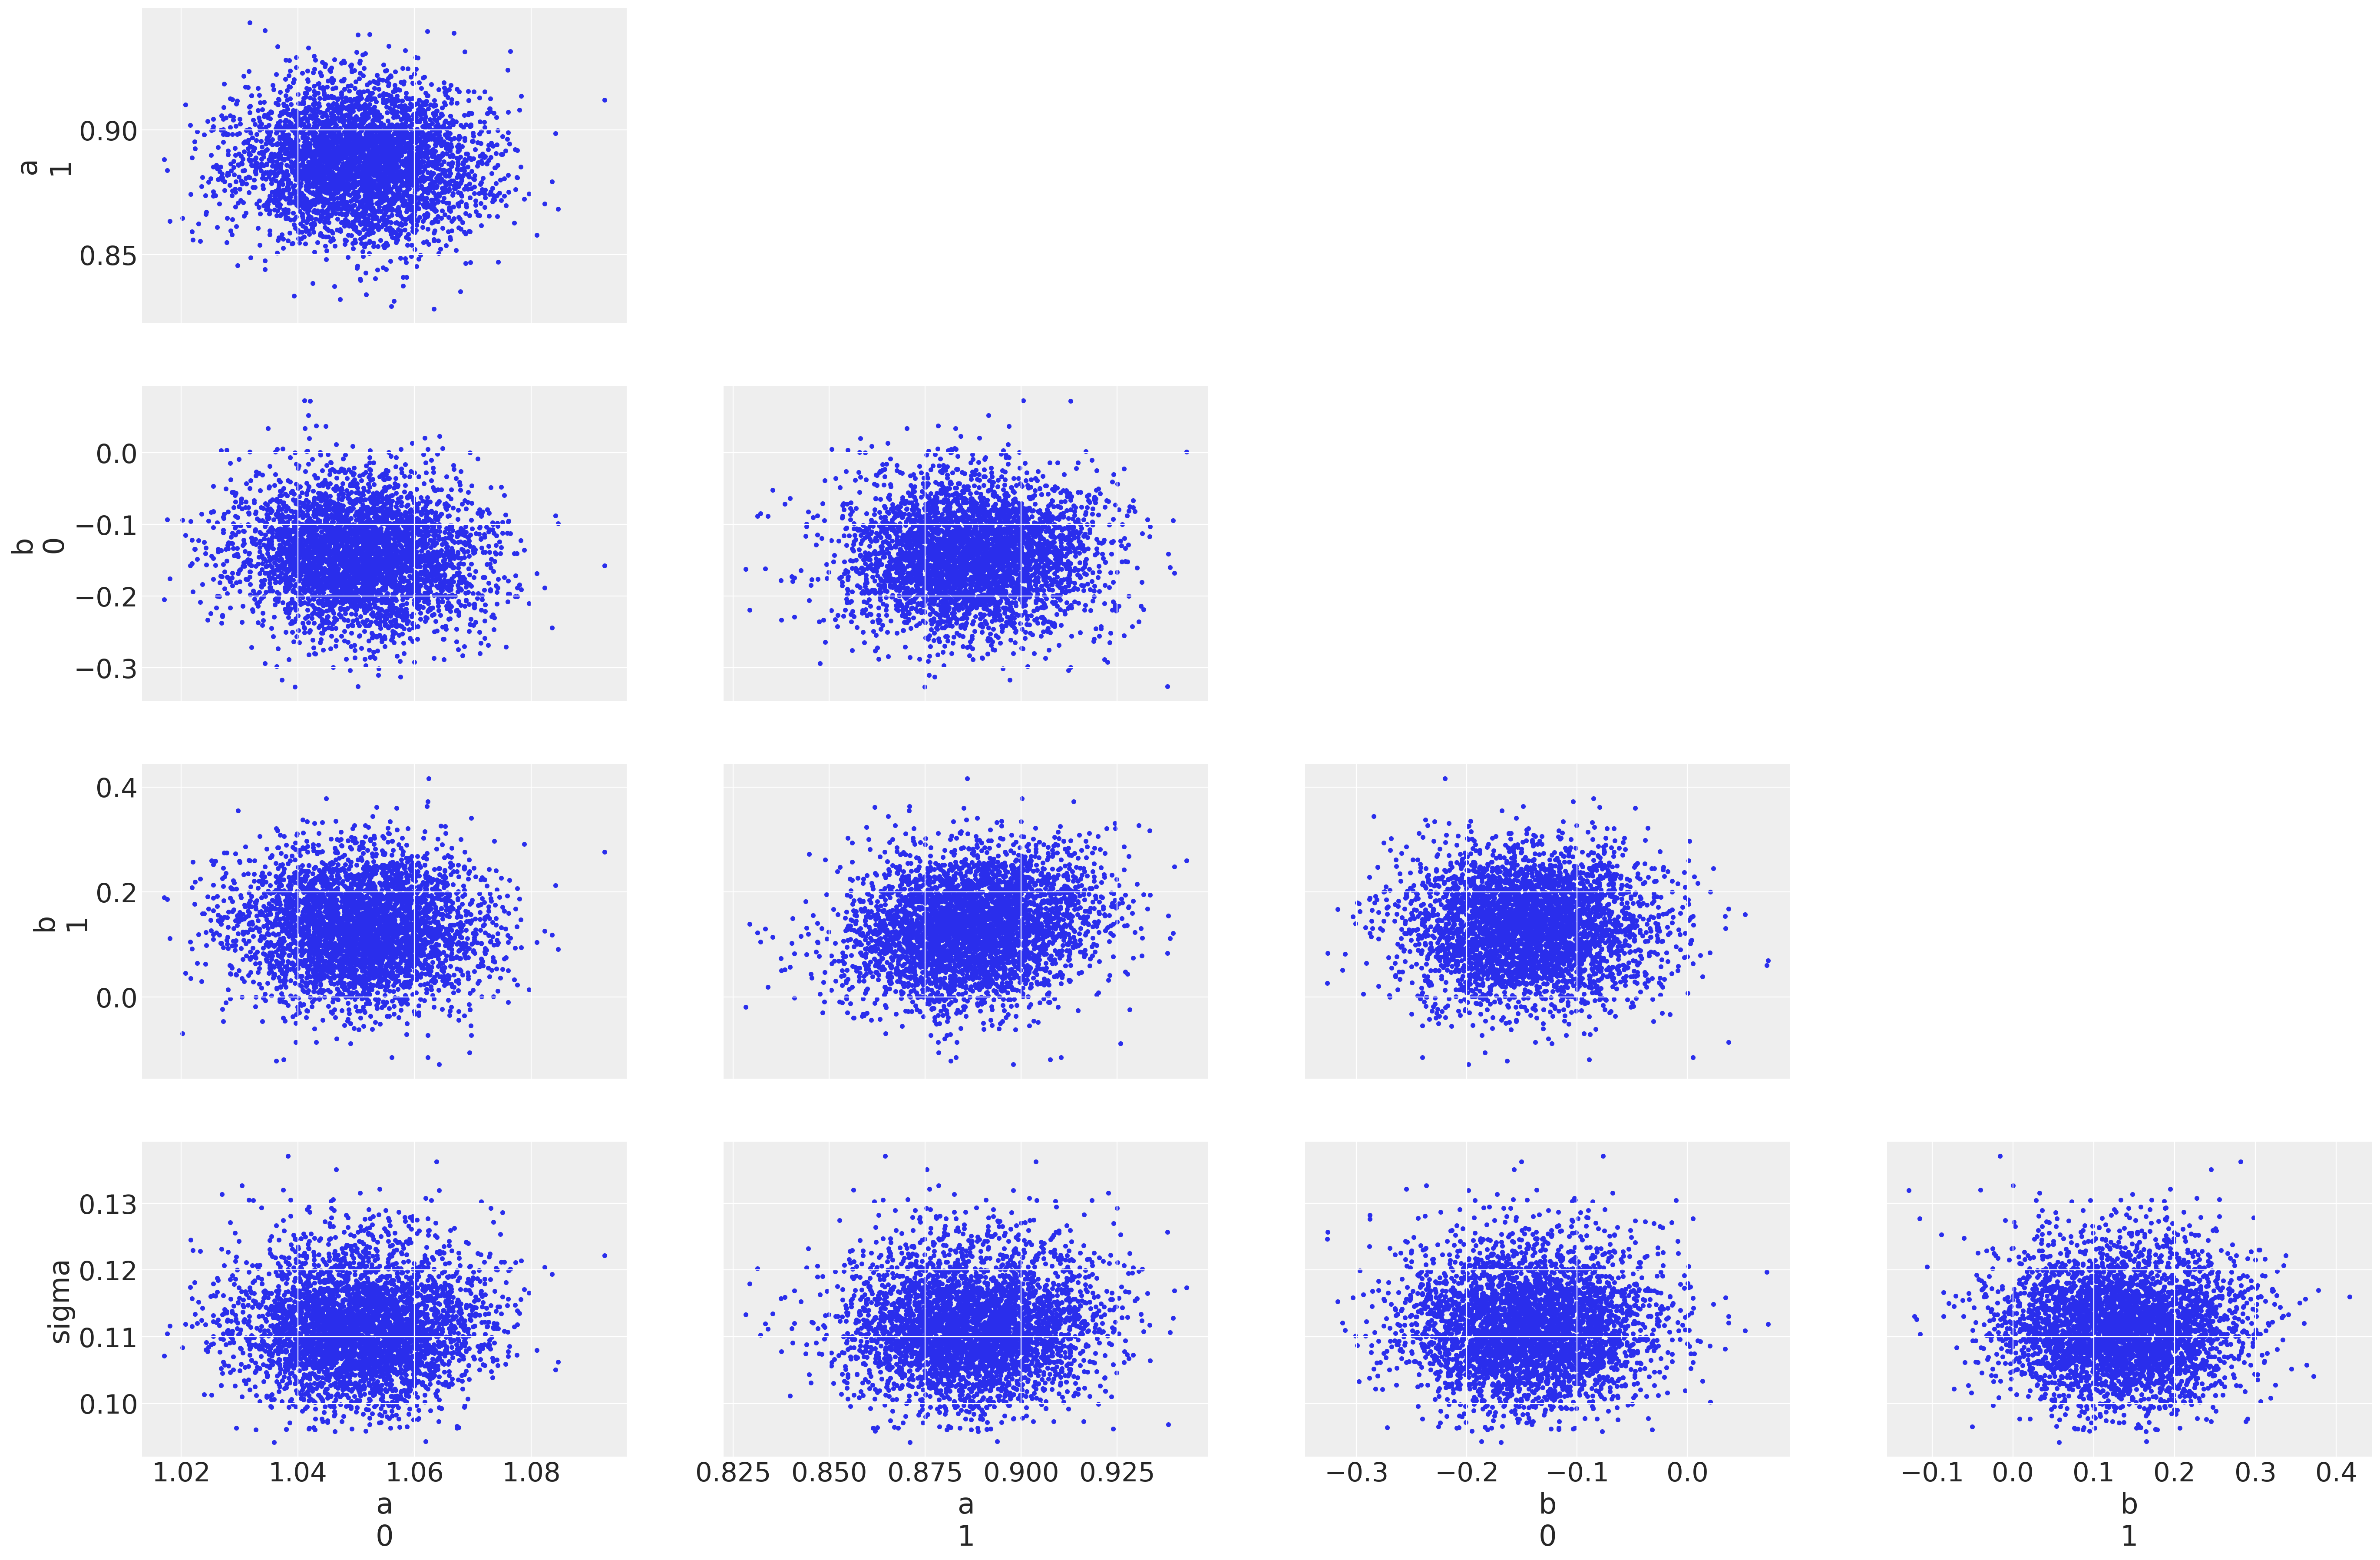

In [14]:
az.plot_pair(
    m8_3_trace, var_names=['a', 'b', 'sigma'], 
    divergences=True, 
    textsize=22, 
    plot_kwargs={'alpha': 0.2})
plt.show()

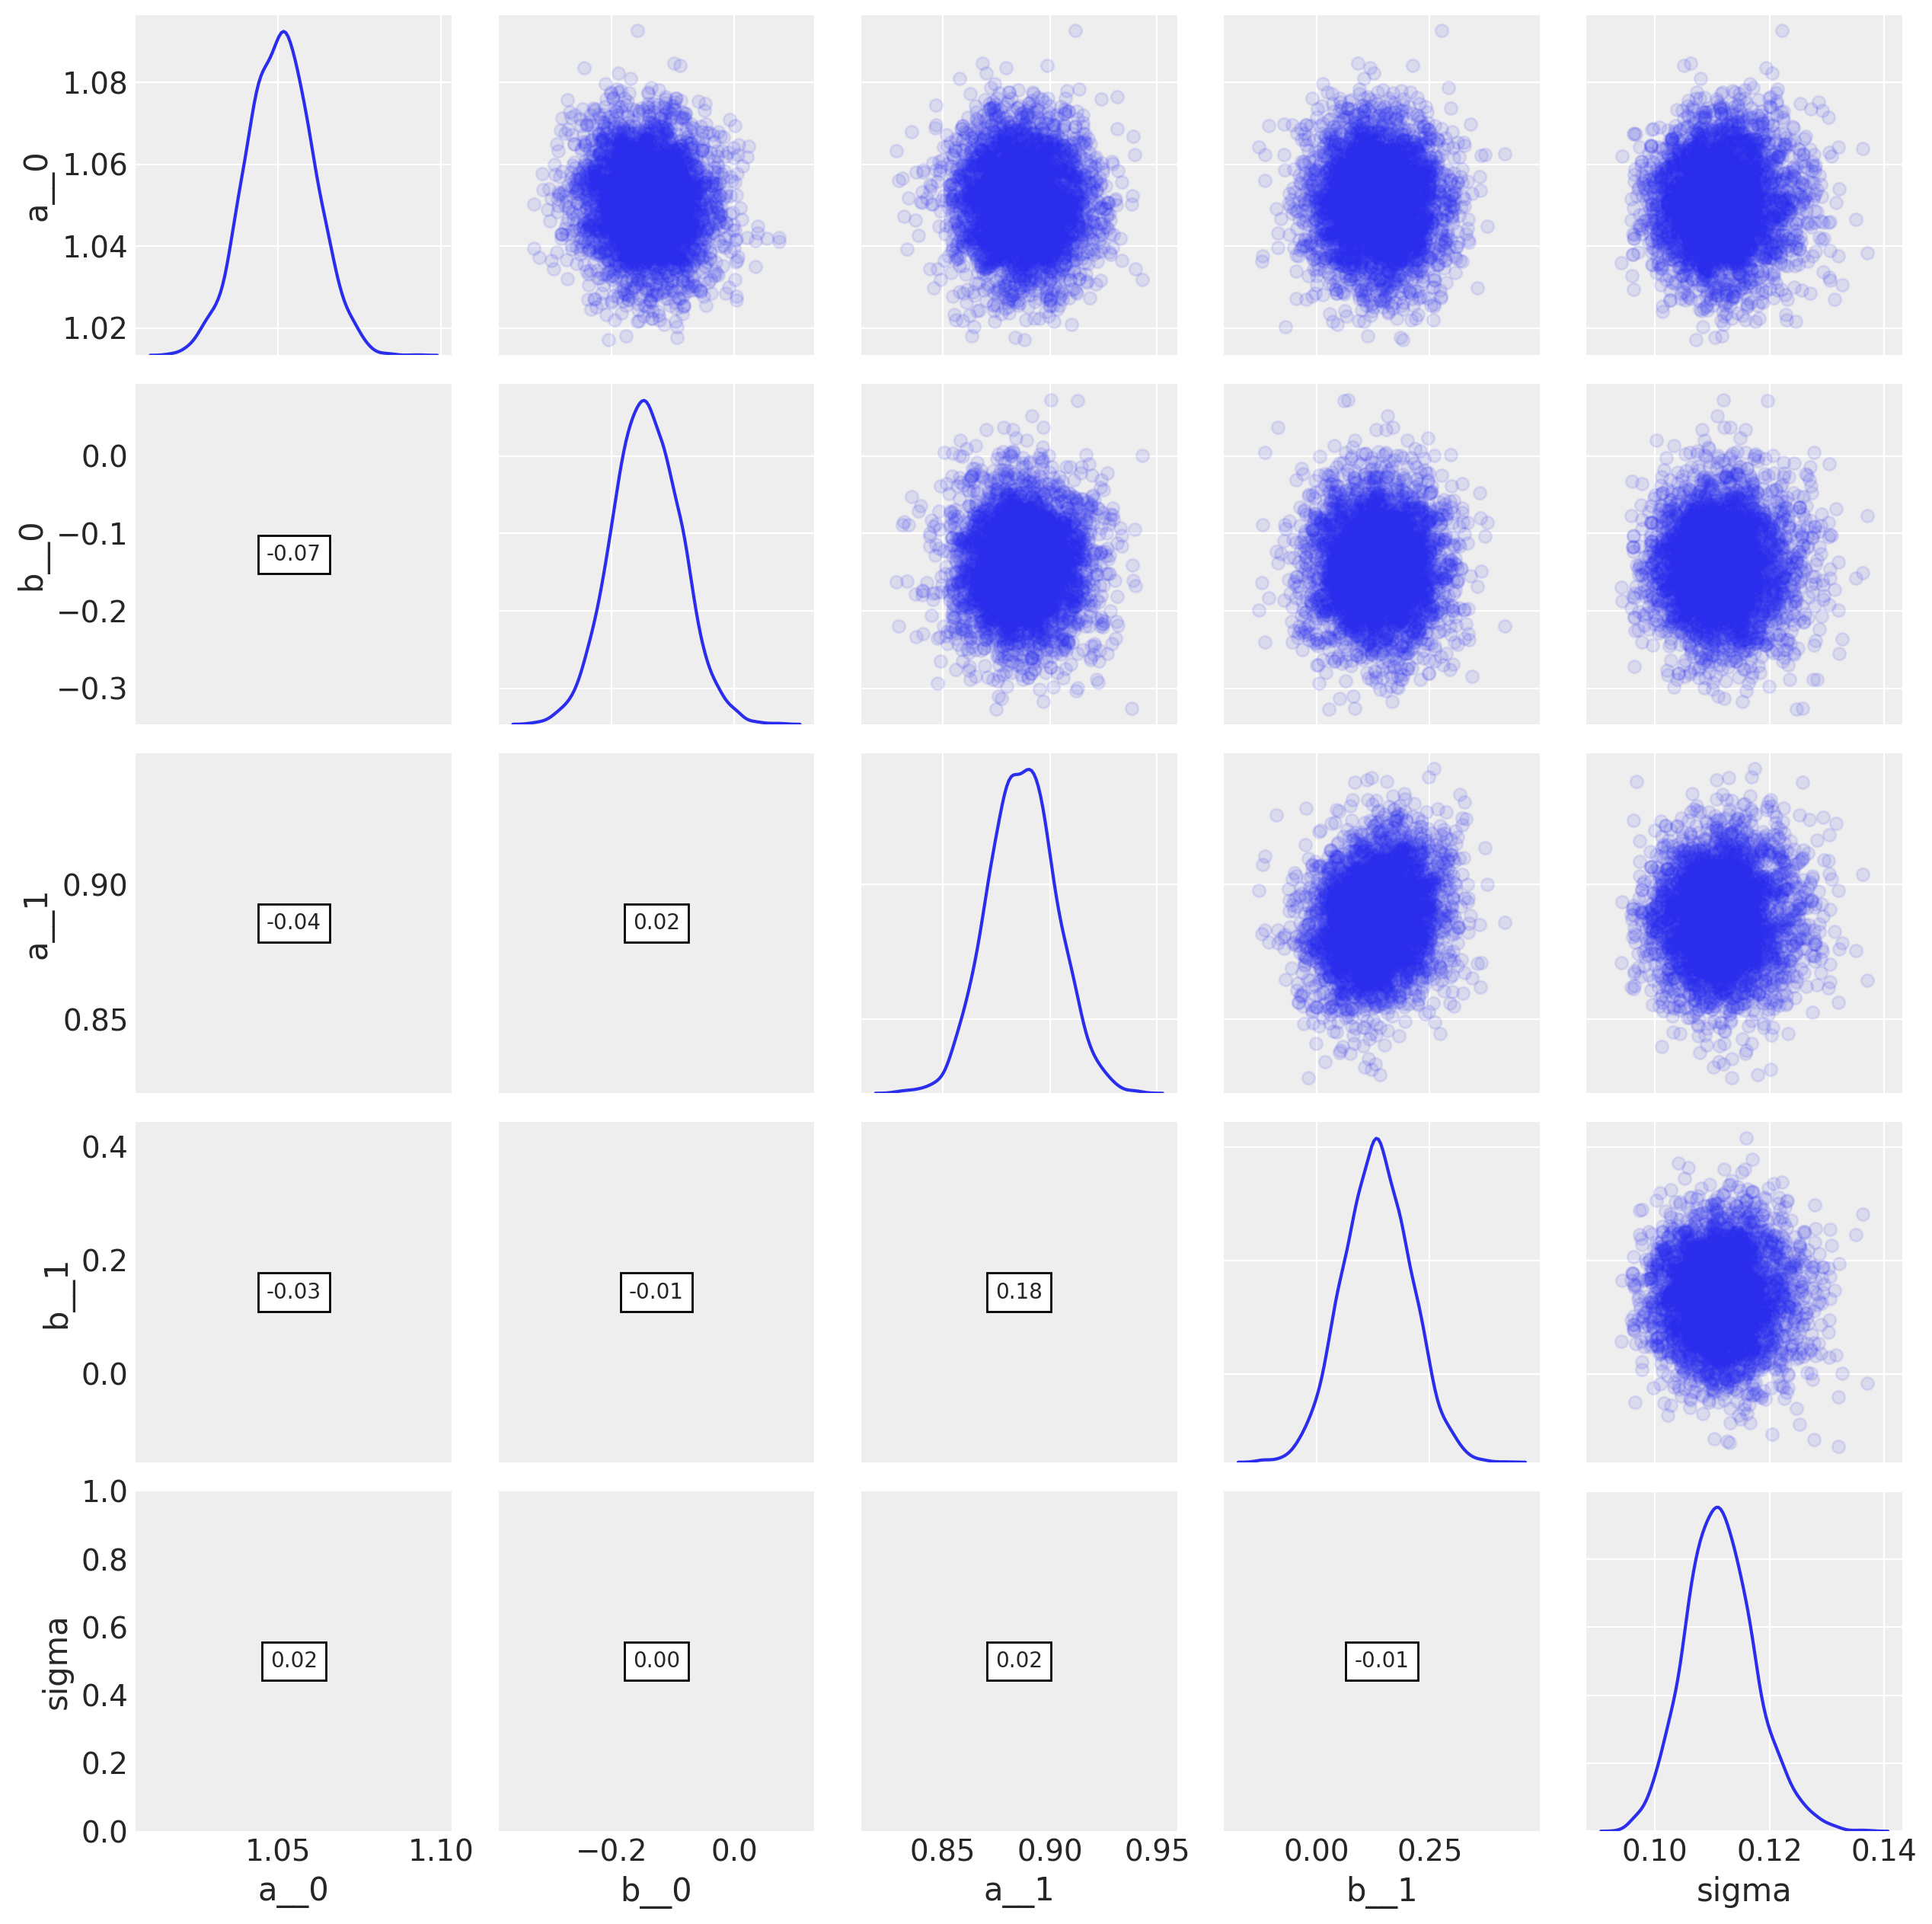

In [15]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

m8_3_trace_df = pm.trace_to_dataframe(m8_3_trace)
grid = (sns.PairGrid(m8_3_trace_df,
                     x_vars=['a__0', 'b__0', 'a__1', 'b__1', 'sigma'],
                     y_vars=['a__0', 'b__0', 'a__1', 'b__1', 'sigma'],
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))

### 9.4.5. Checking the chain

**Trace Plot** A trace plot merely plots the samples in sequential order, joined by a line. 

### Code 9.20

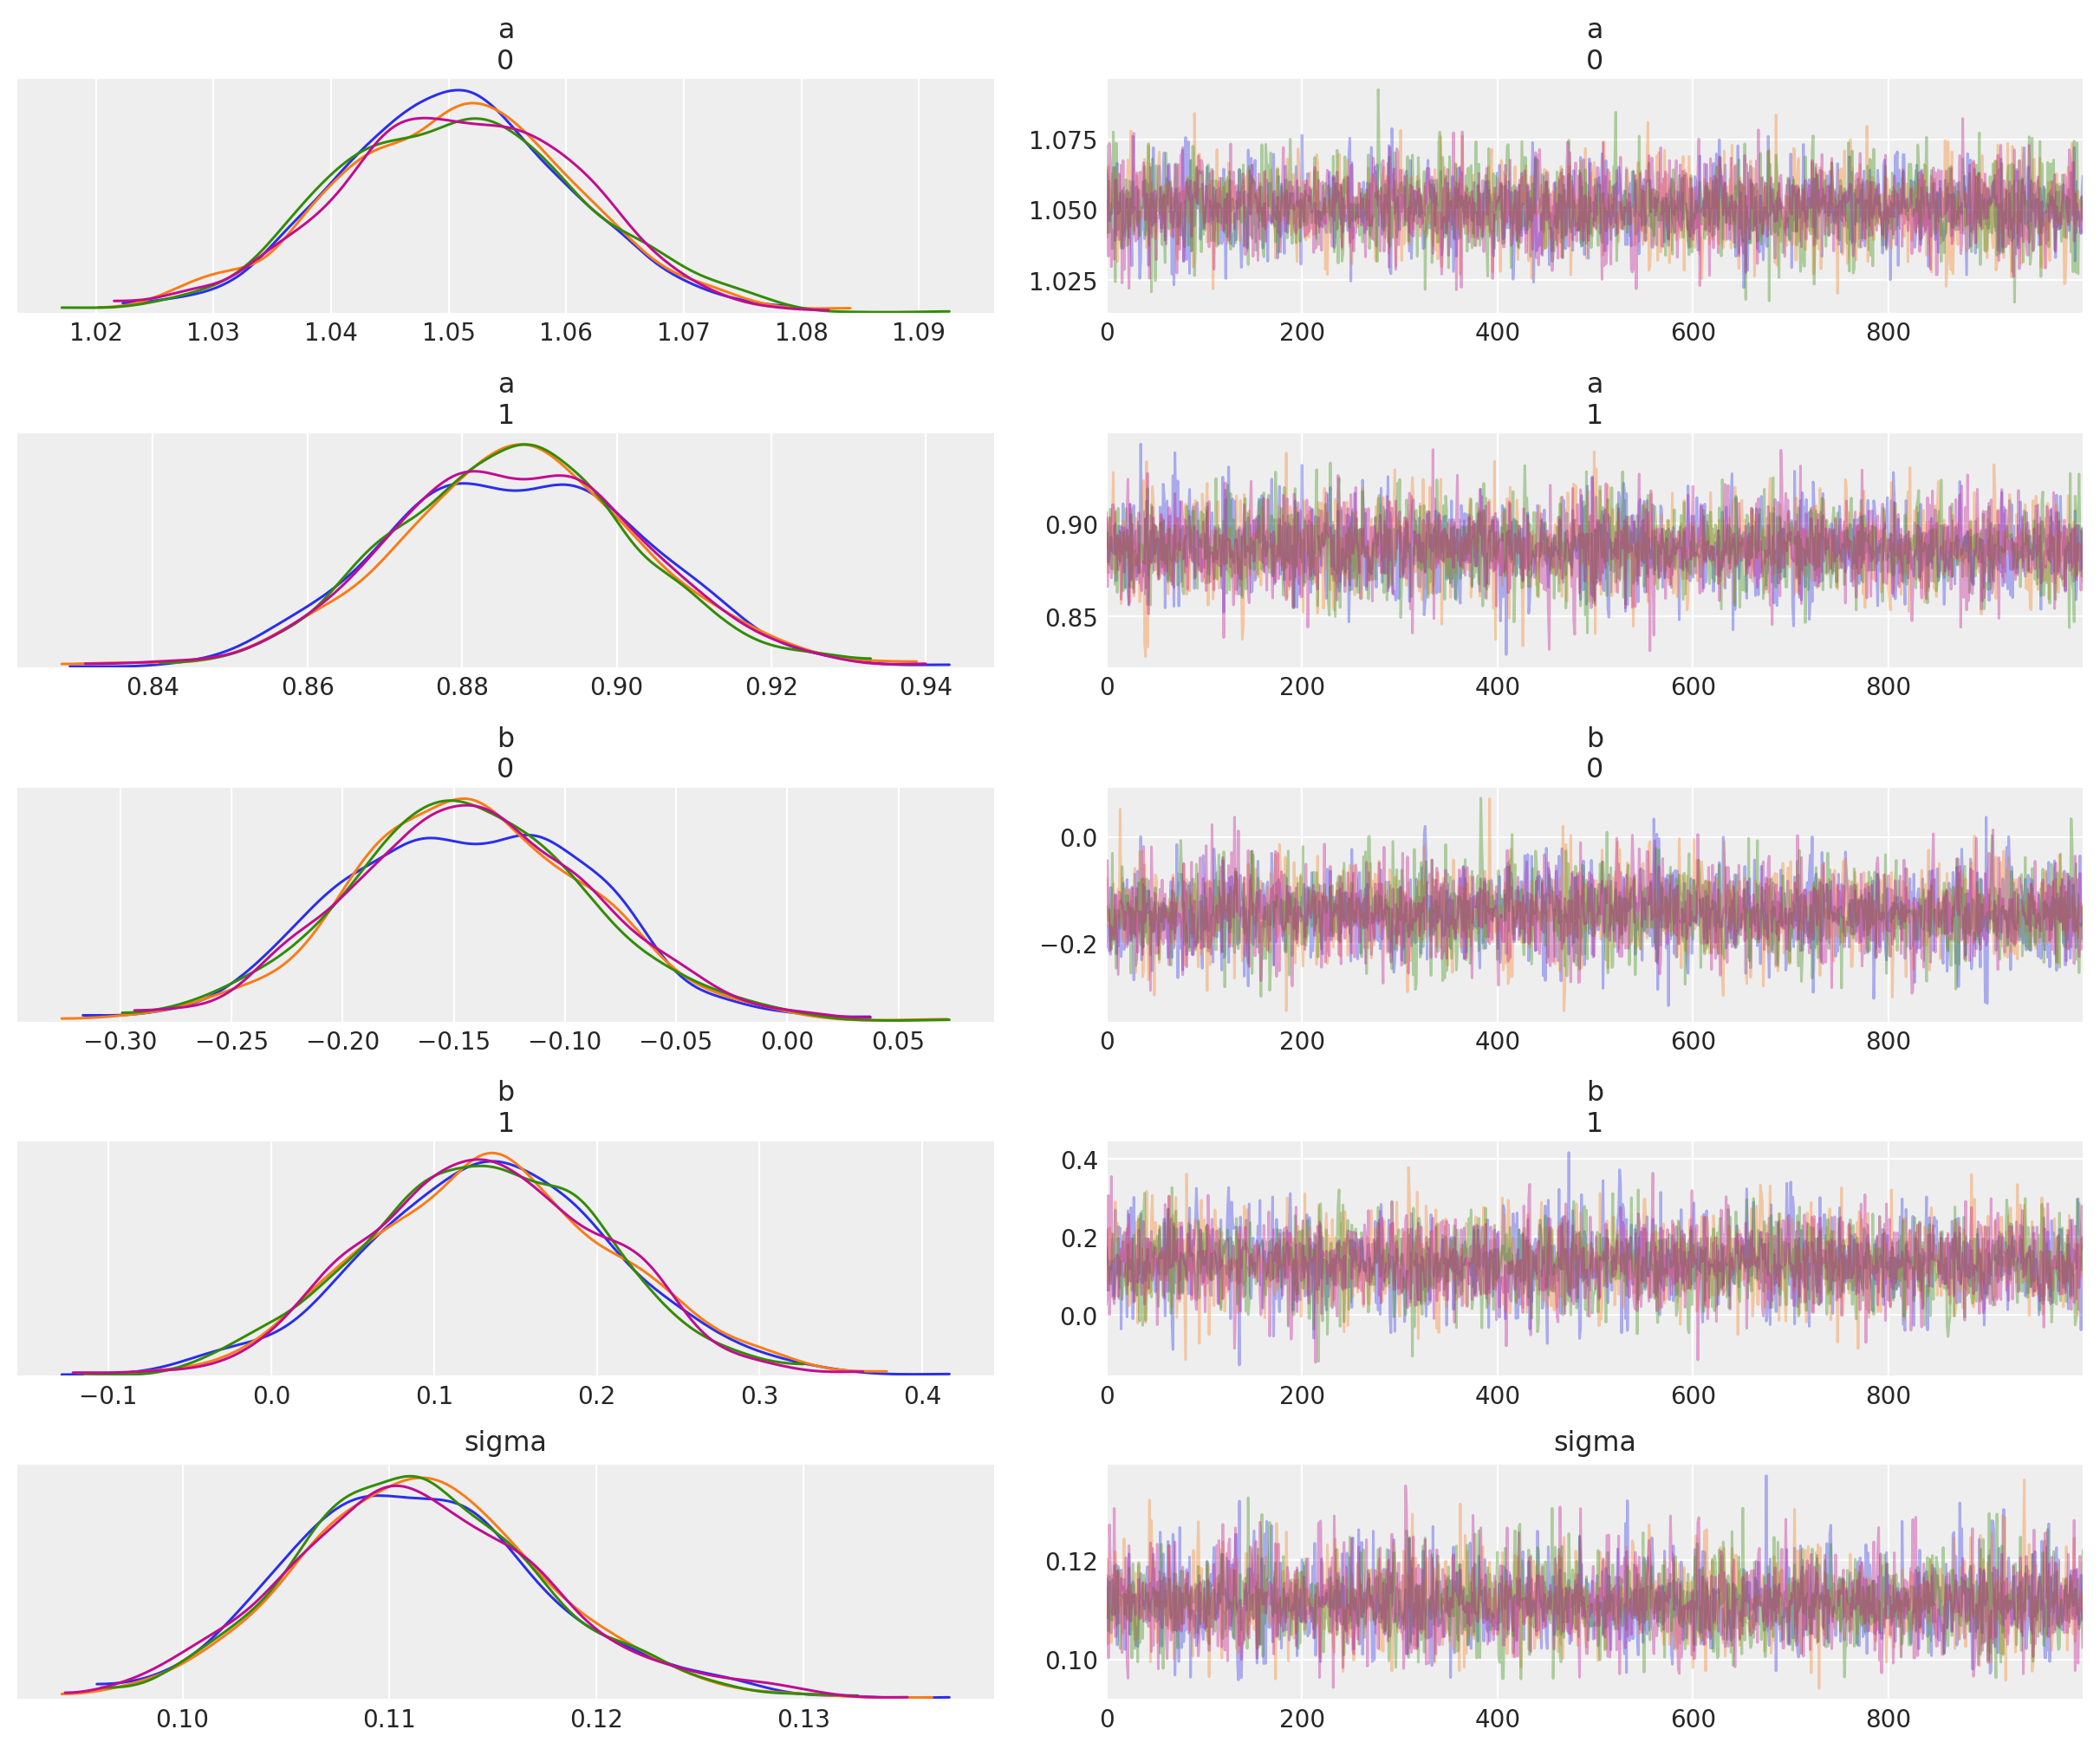

In [16]:
az.plot_trace(m8_3_trace, 
              var_names=(['a','b','sigma']))
plt.show()

Now, how is this chain a healthy one? Typically we look for three things in these trace plots:
1. **Stationarity.** Stationarity refers to the path of each chain staying within the same high-probability portion of the posterior distribution. Good mixing means that the chain rapidly explores the full region. It doesn’t slowly wander, but rather rapidly zig-zags around, as a good Hamiltonian chain should.
2. **Good Mixing.** Good mixing means that the chain rapidly explores the full region. It doesn’t slowly wander, but rather rapidly zig-zags around, as a good Hamiltonian chain should.  
3. **Convergence.** Convergence means that multiple, independent chains stick around the same region of high probability.


 

### Code 9.21

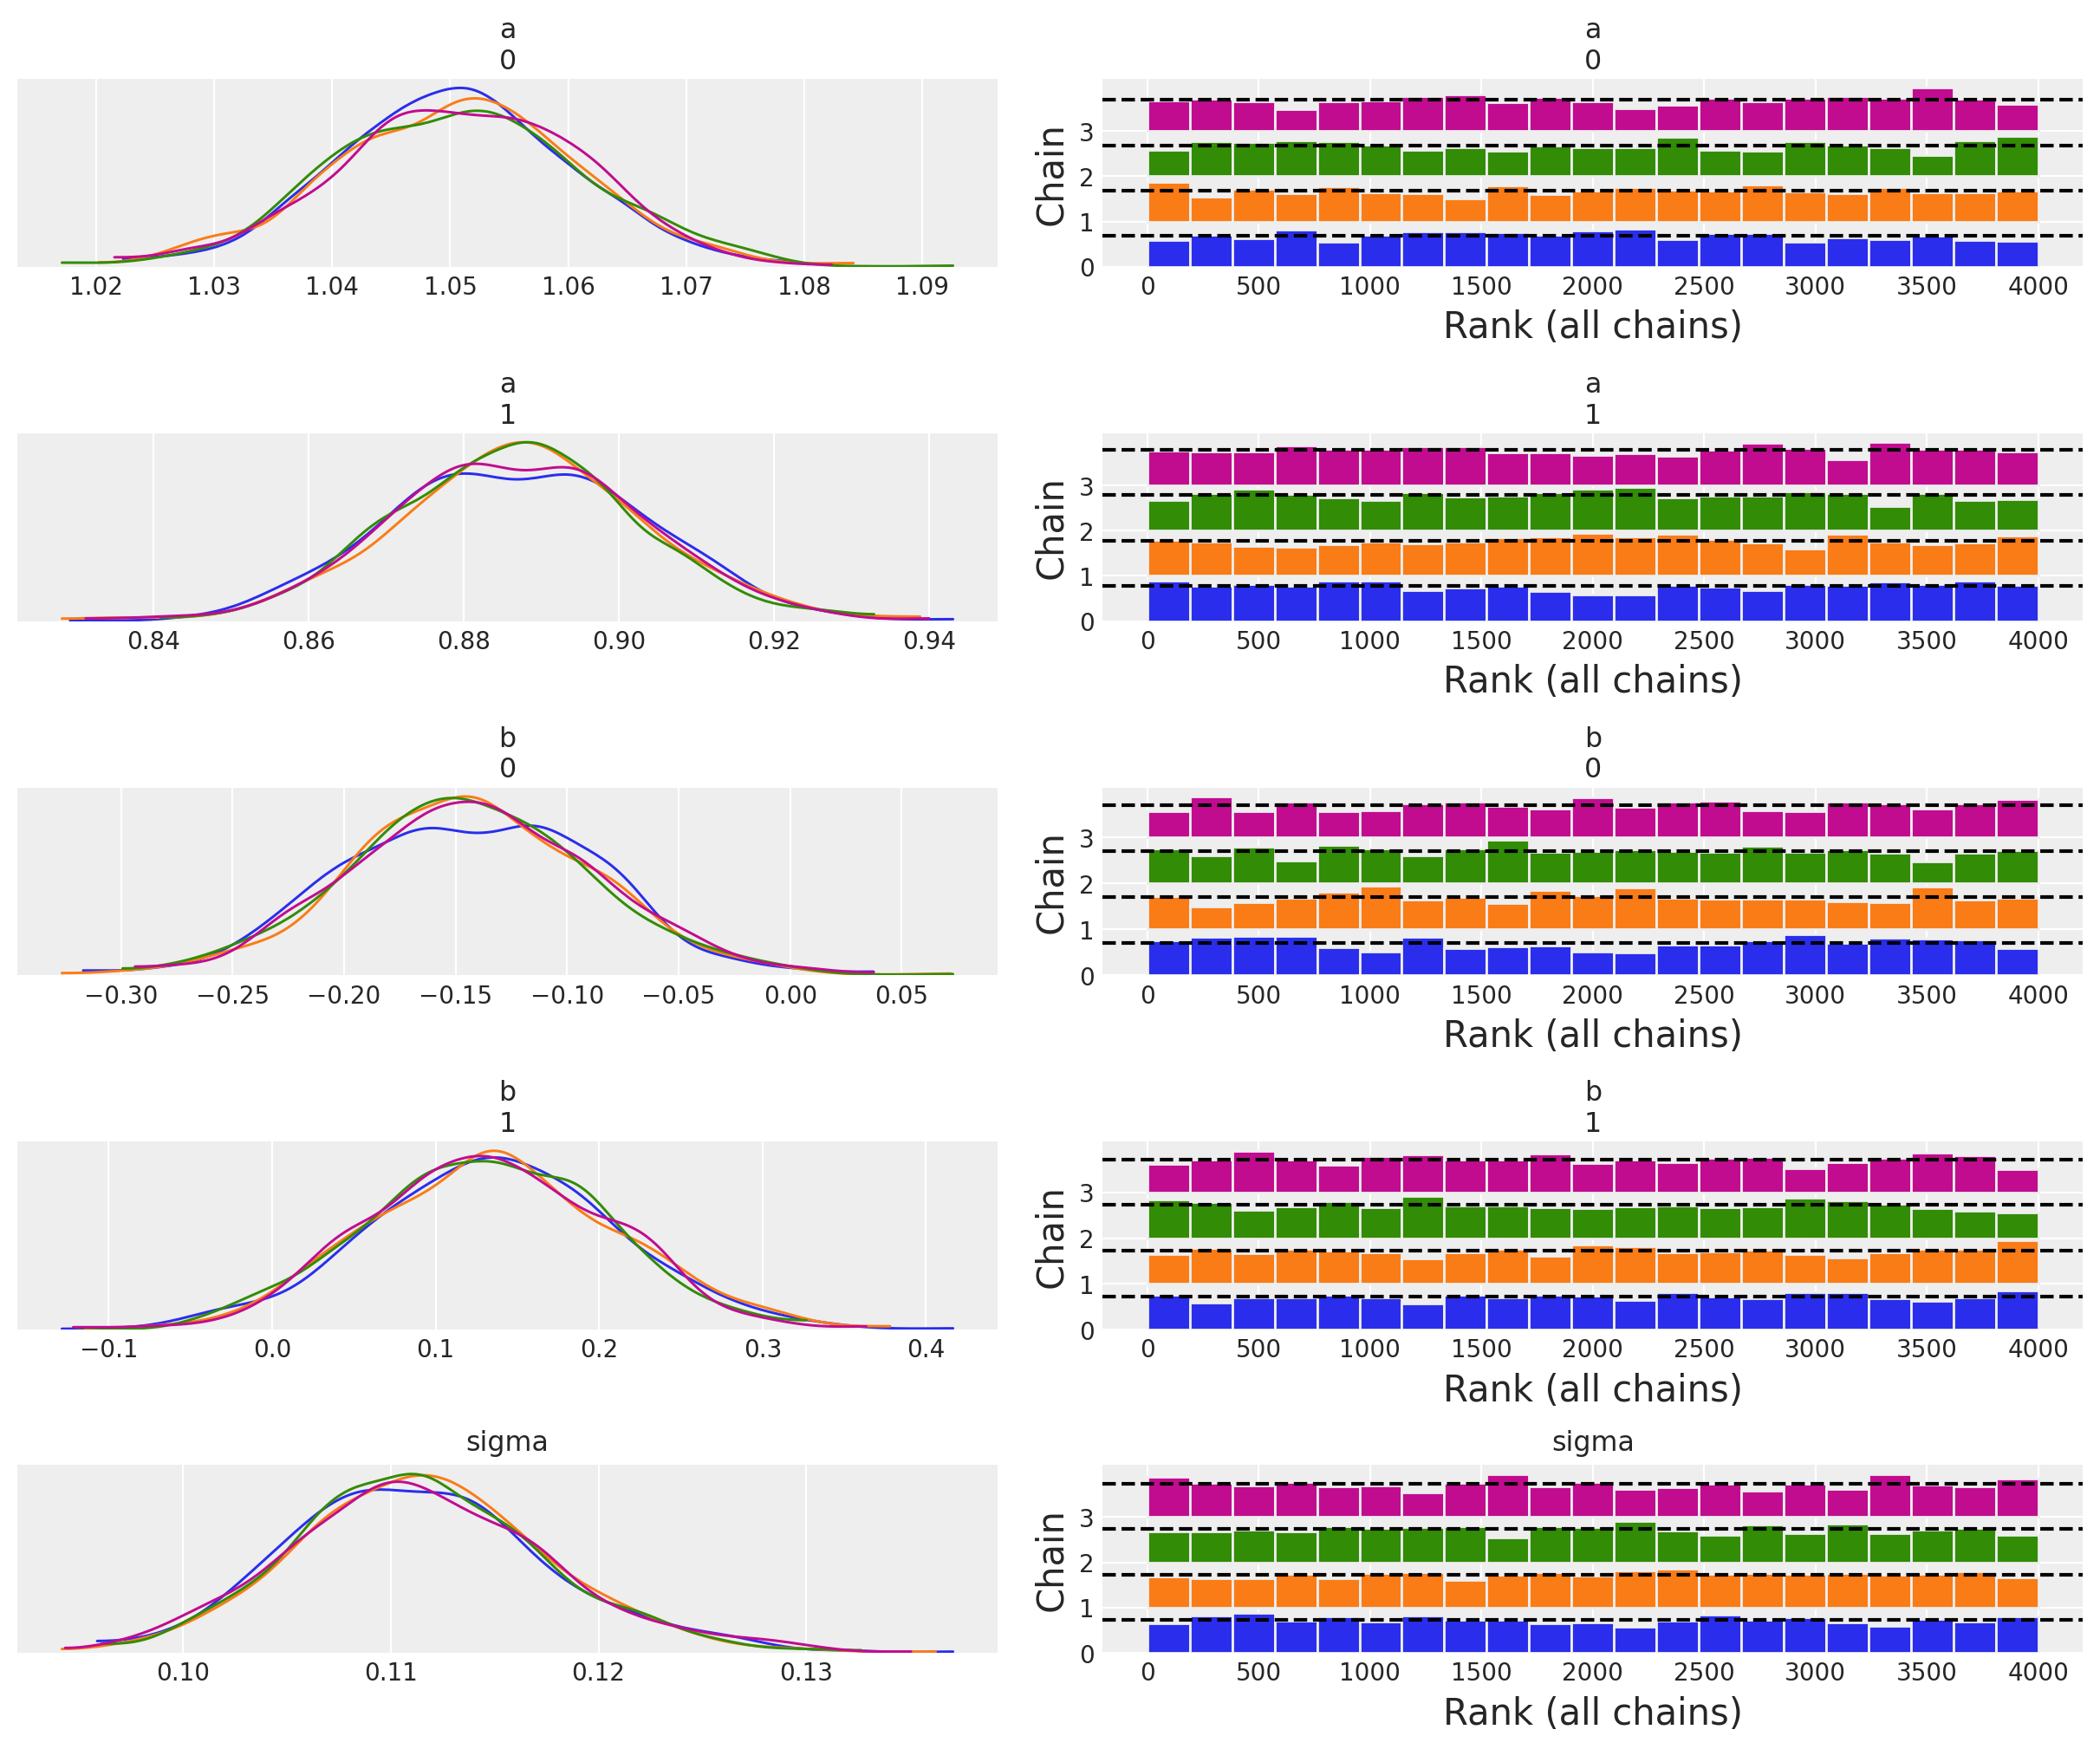

In [17]:
az.plot_trace(m8_3_trace, 
              var_names=(['a','b','sigma']),
              kind = 'rank_bars')
plt.show()

**This trank plot is what we hope for: Histograms that overlap and stay within the same range.**

## 9.5. Care and feeding of your Markov chain

### 9.5.1. How many samples do you need? 

what really matters is the effective number of samples, not the raw number. The effective number of samples is an estimate of the number of independent sam- ples from the posterior distribution. Markov chains are typically autocorrelated, so that se- quential samples are not entirely independent. This reduces the effective number of samples.

### 9.5.2. How many chains do you need?

one short chain to debug, four chains for verification and inference.

### 9.5.3. Taming a wild chain

### Code 9.22  and Code 9.23

In [18]:
y = np.array([-1., 1.])

In [19]:
# define model: y ~ (mu, sigma)
with pm.Model() as m9_2:
    alpha = pm.Normal('alpha', mu=0, sd=1000)
    sigma = pm.Exponential('sigma', 0.0001)
    mu = pm.Deterministic('mu', alpha)
    y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    m9_2_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]
Sampling 4 chains, 656 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2608.29draws/s]
There were 211 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5380086912439883, but should be close to 0.8. Try to increase the number of tuning steps.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5870639519383443, but should be close to 0.8. Try to increase the number of tuning steps.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5644579860791751, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target

In [20]:
# show model summary
varnames = ['~mu']
az.summary(m9_2_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean       sd  hdi_5.5%  hdi_94.5%
alpha   12.16   404.06   -527.46     615.58
sigma  711.75  1427.84      8.61    1652.32

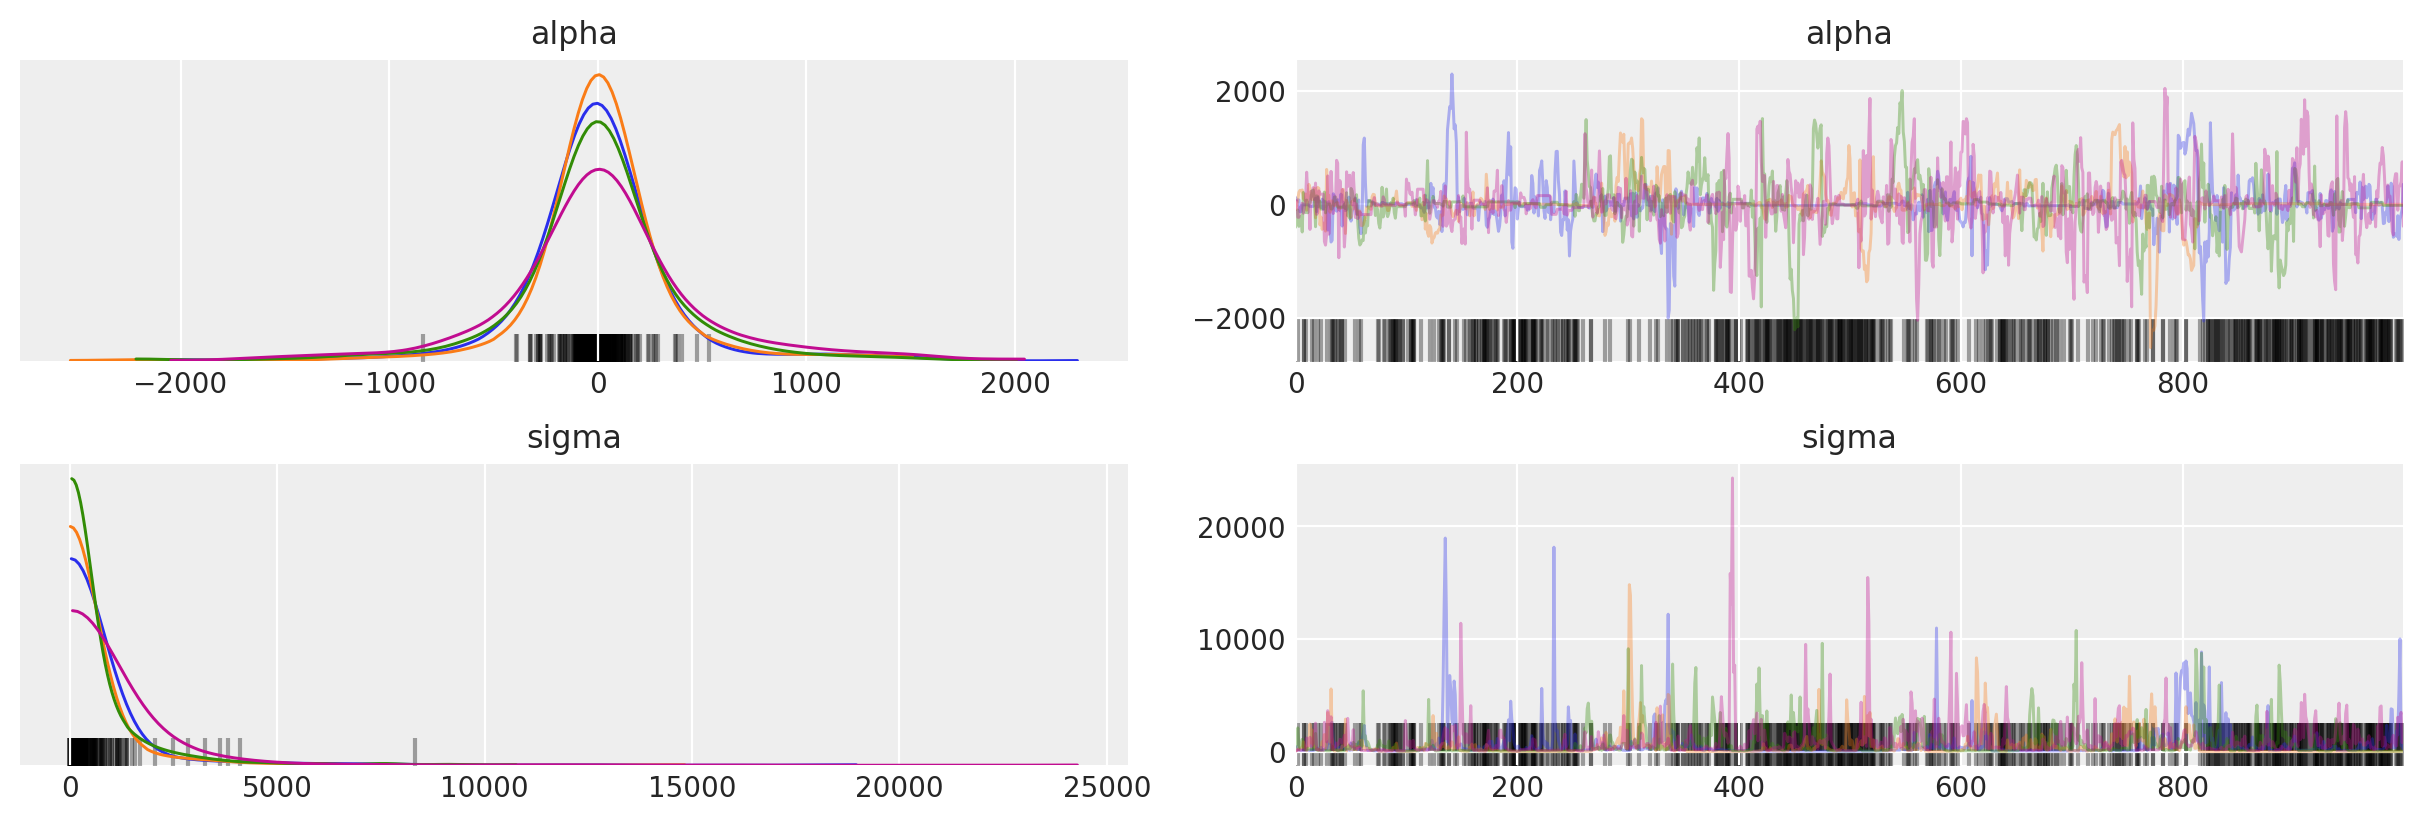

In [21]:
az.plot_trace(m9_2_trace, 
              var_names=(['alpha','sigma']))
plt.show()

In [22]:
az.ess(m9_2_trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 945.5
    sigma    float64 39.03
    mu       float64 945.5

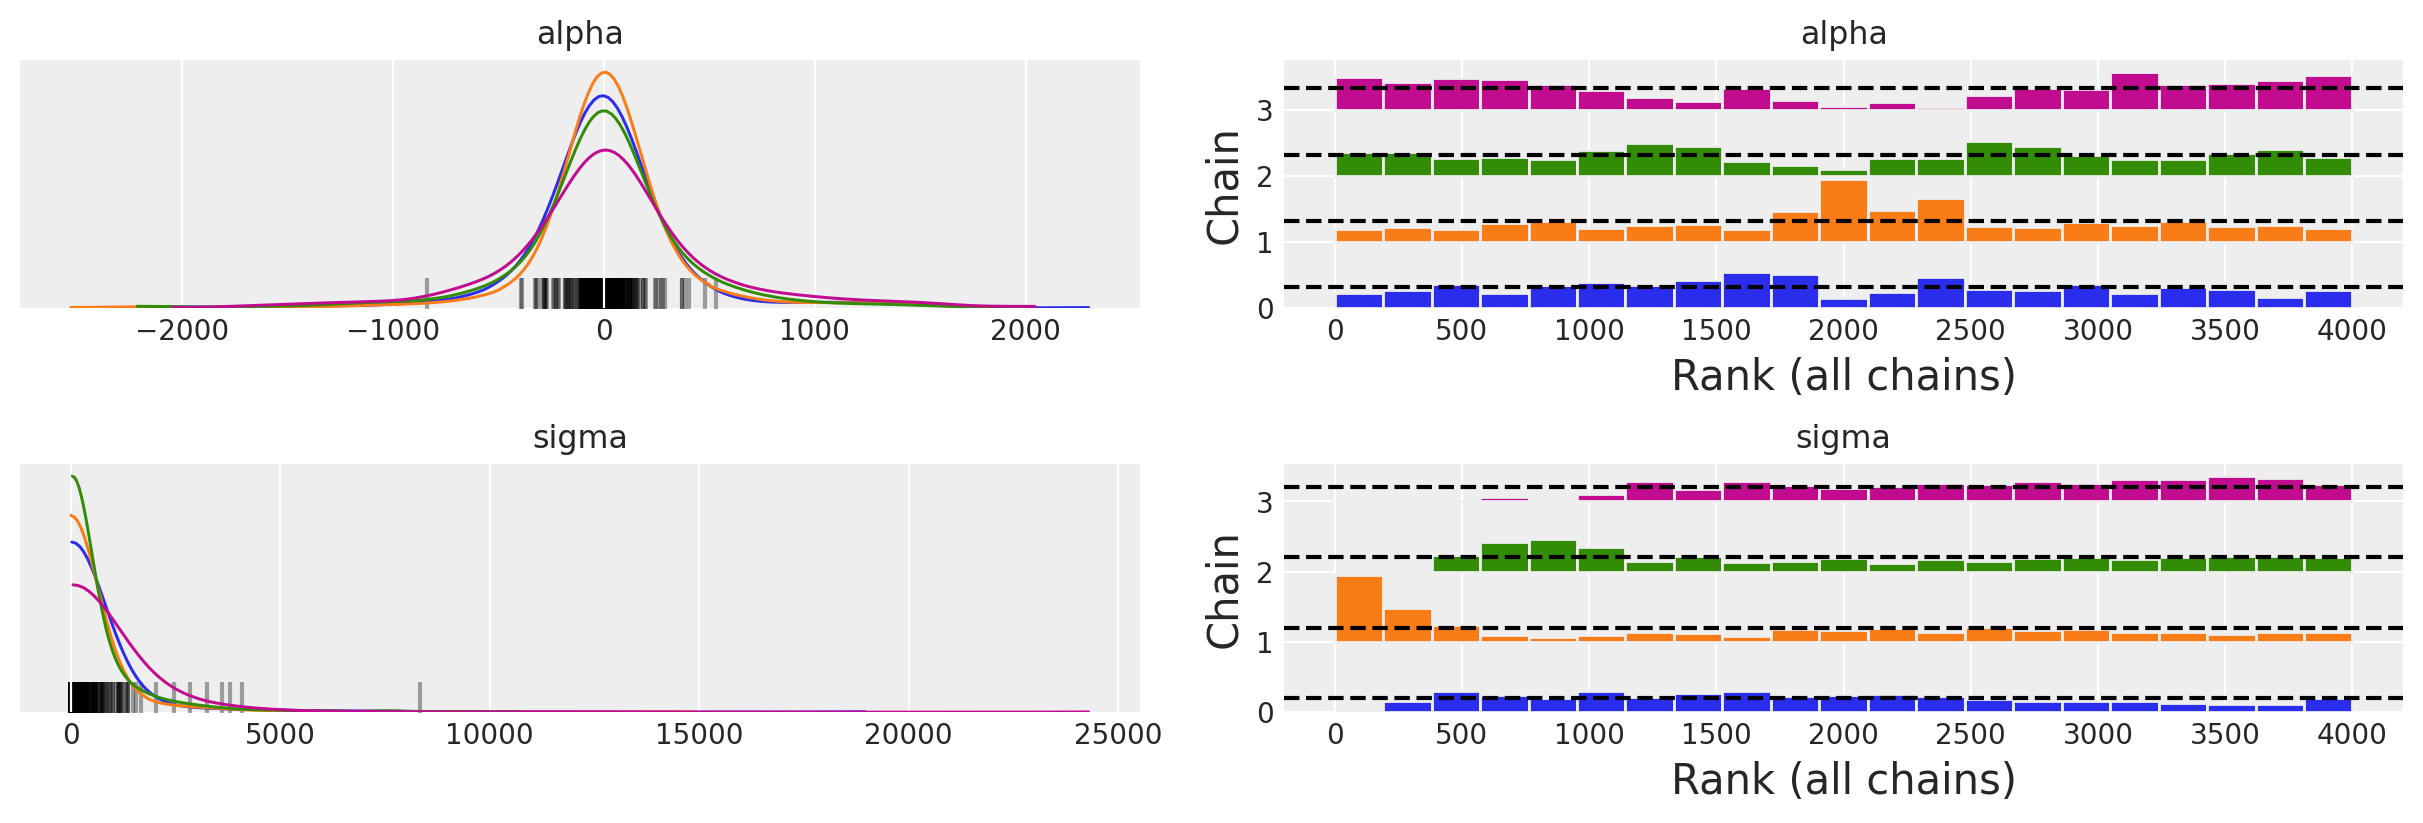

In [23]:
az.plot_trace(m9_2_trace, 
              var_names=(['alpha','sigma']),
              kind = 'rank_bars')
plt.show()

### Code 9.24

In [24]:
# define model: y ~ (mu, sigma)
with pm.Model() as m9_3:
    alpha = pm.Normal('alpha', mu=1, sd=10)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha)
    y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    m9_3_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]
Sampling 4 chains, 16 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4027.69draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
# show model summary
varnames = ['~mu']
az.summary(m9_3_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
alpha  0.01  1.25     -1.79       1.82
sigma  1.53  0.84      0.52       2.54

In [26]:
az.ess(m9_3_trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 1.391e+03
    sigma    float64 936.6
    mu       float64 1.391e+03

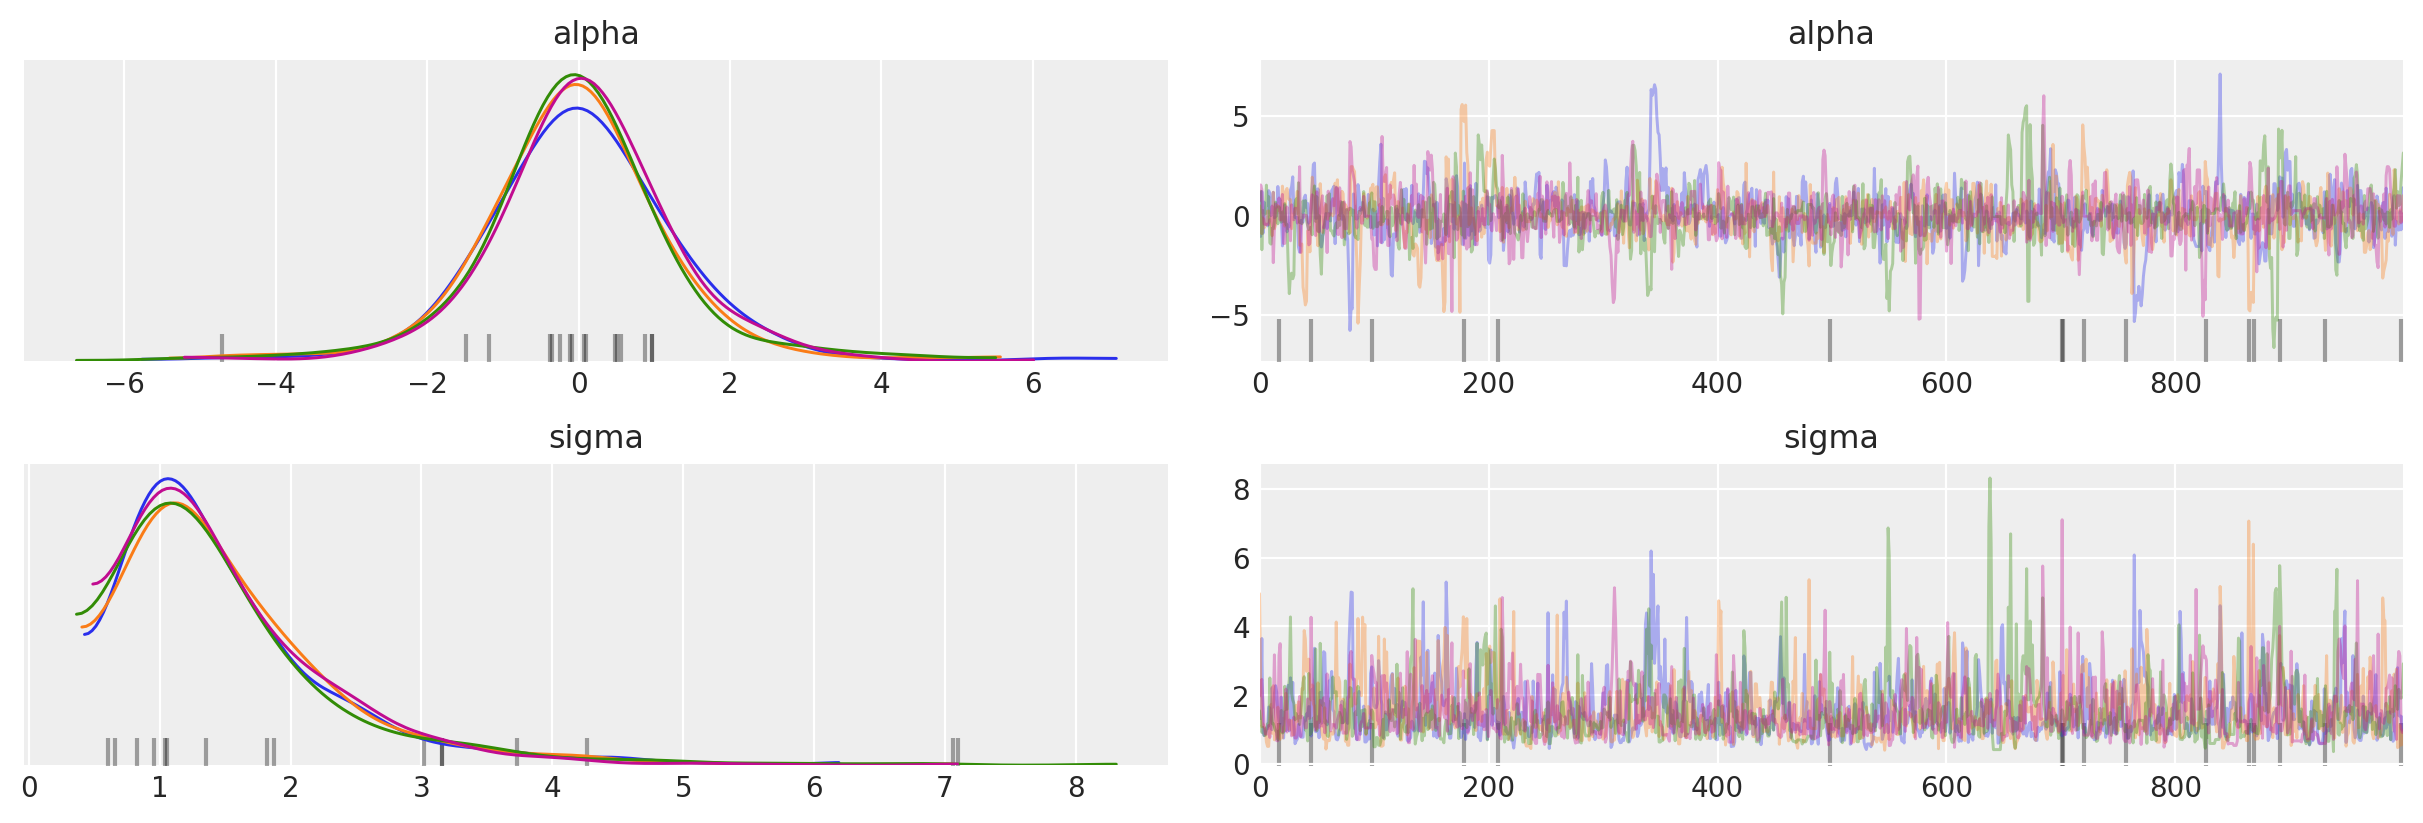

In [27]:
az.plot_trace(m9_3_trace, 
              var_names=(['alpha','sigma']))
plt.show()

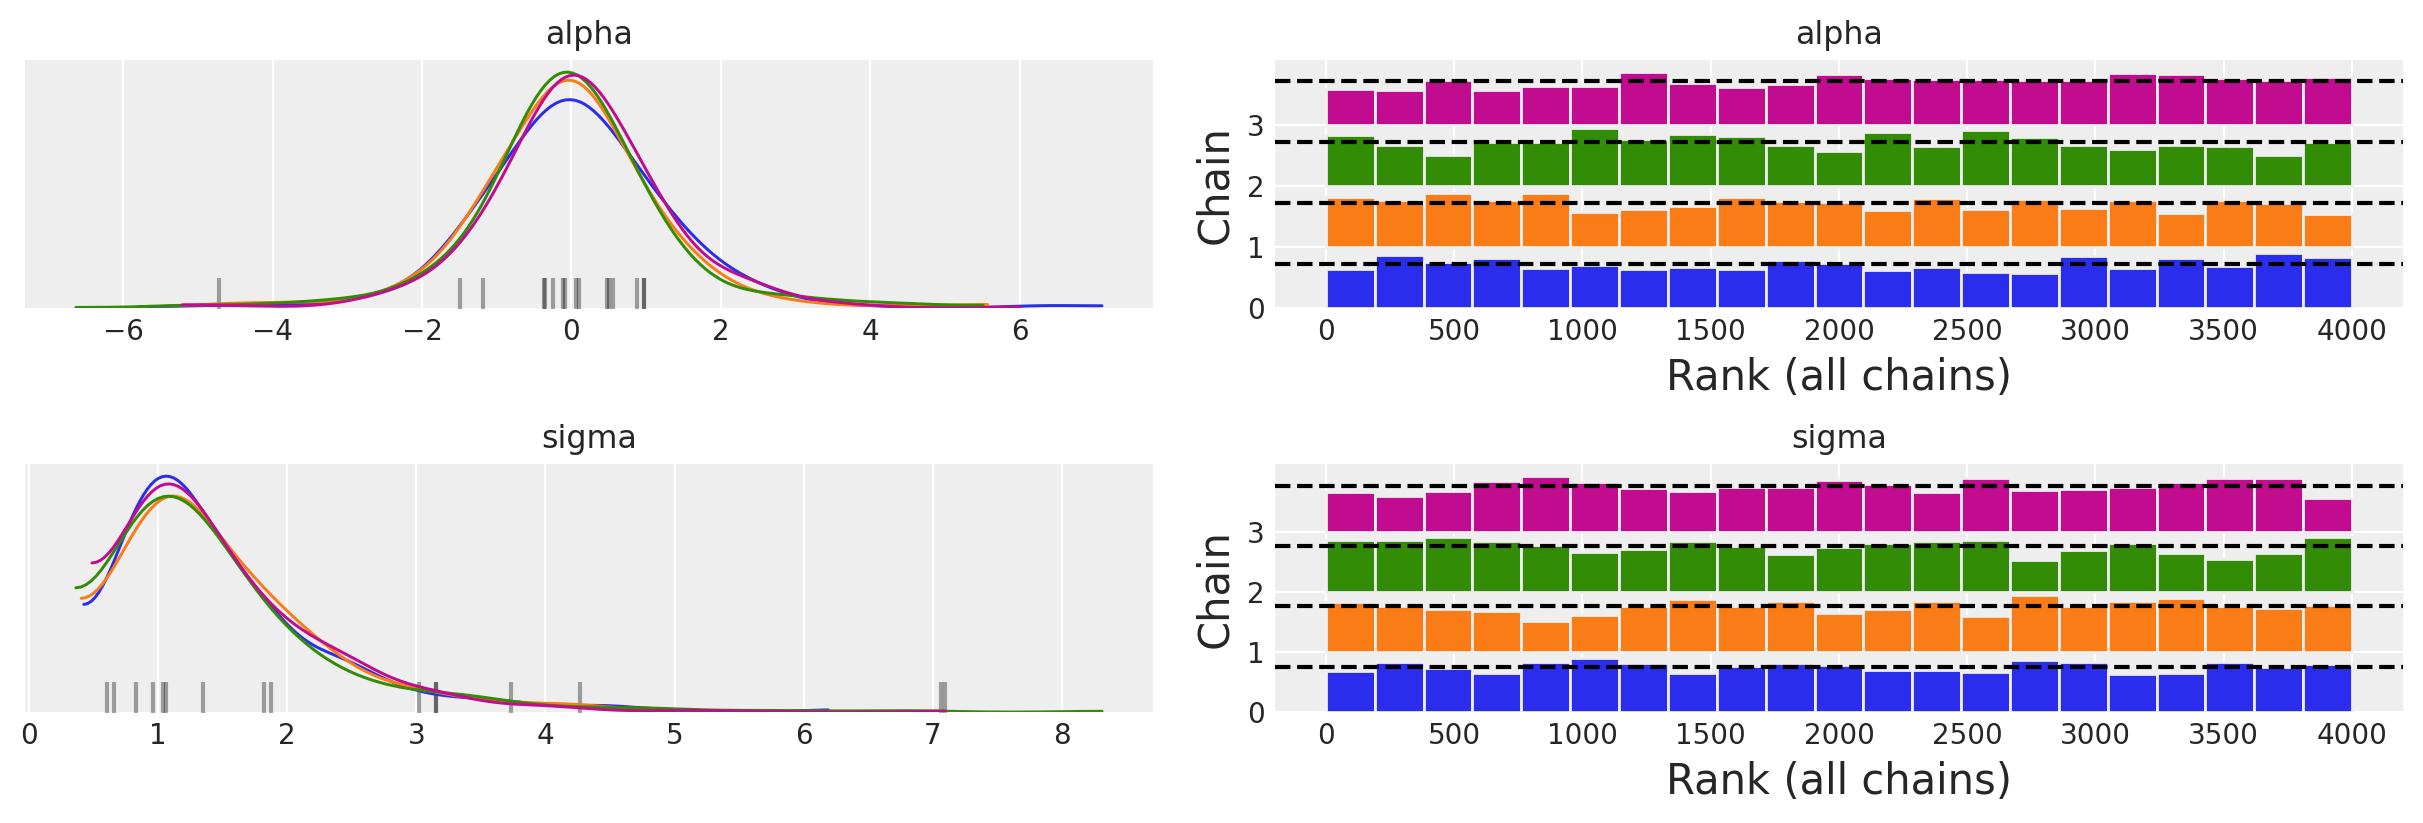

In [28]:
az.plot_trace(m9_3_trace, 
              var_names=(['alpha','sigma']),
              kind = 'rank_bars')
plt.show()

### 9.5.4. Non-identifiable parameters

### Code 9.25

In [29]:
y = stats.norm.rvs(loc=0, scale=1, size=100)

### Code 9.26

In [30]:
# define model: y ~ a1+a2
with pm.Model() as m9_4:
    a1 = pm.Normal('a1', mu=0, sd=1000)
    a2 = pm.Normal('a2', mu=0, sd=1000)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a1+a2)
    y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    m9_4_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a2, a1]
Sampling 4 chains, 859 divergences: 100%|██████████| 8000/8000 [03:08<00:00, 42.35draws/s] 
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.272245431187263, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1302828072127622, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6854210718679687, but should be close to 

In [31]:
# show model summary
varnames = ['~mu']
az.summary(m9_4_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean      sd  hdi_5.5%  hdi_94.5%
a1     58.32  430.74   -567.00     591.74
a2    -58.37  430.74   -591.79     566.97
sigma   0.87    0.04      0.83       0.94

In [32]:
az.ess(m9_4_trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    a1       float64 5.38
    a2       float64 5.379
    sigma    float64 17.03
    mu       float64 1.9e+03

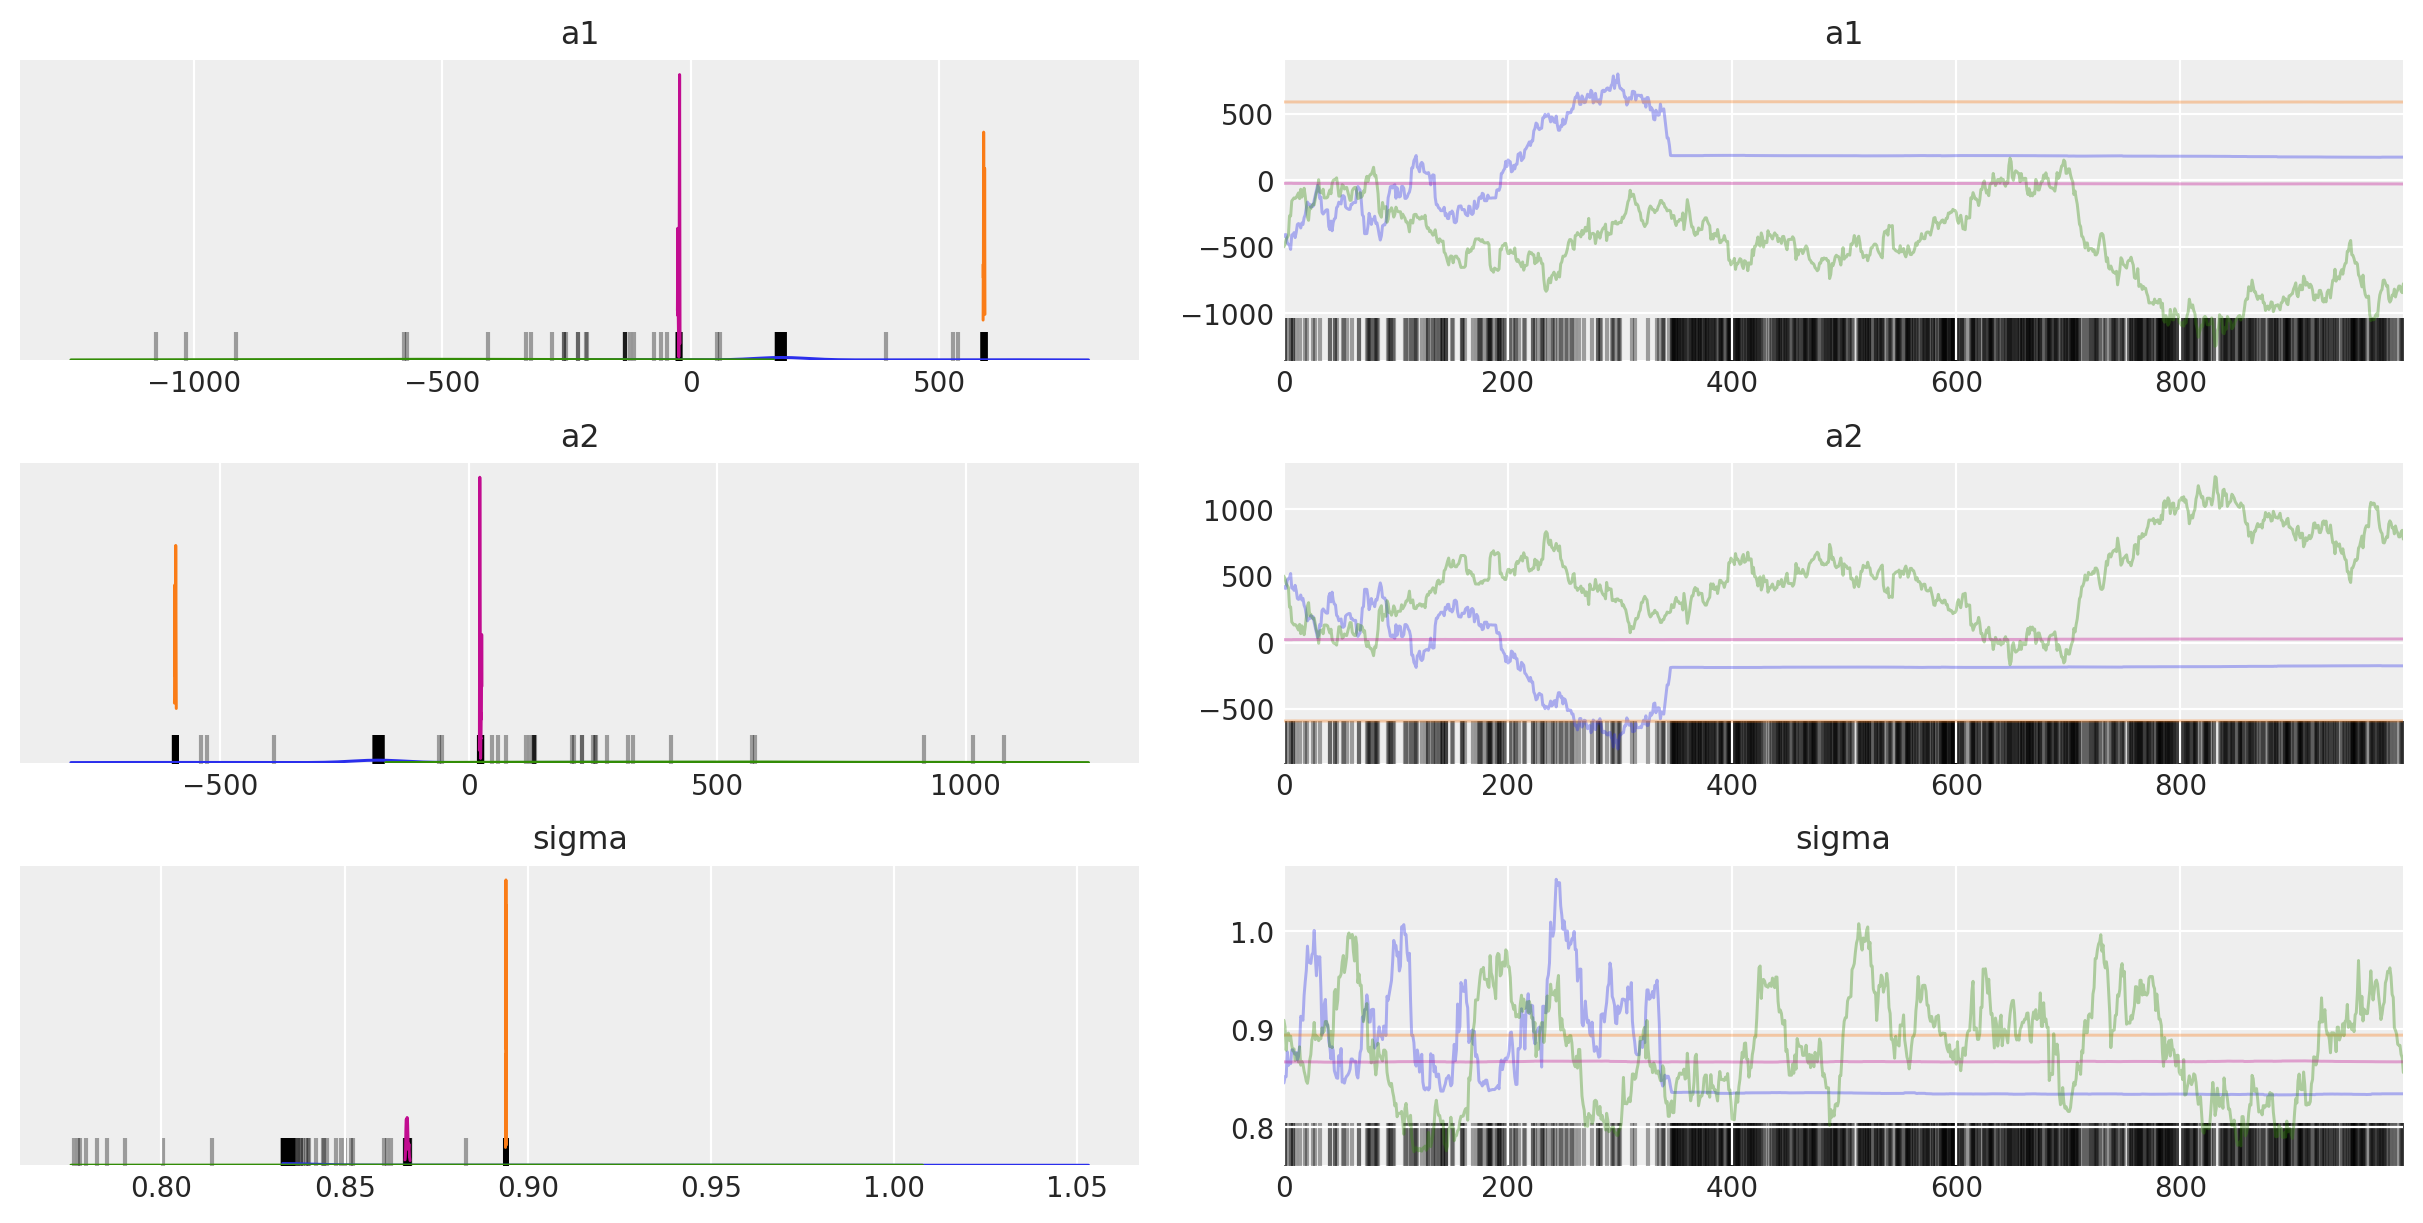

In [33]:
az.plot_trace(m9_4_trace, 
              var_names=(['a1','a2','sigma']))
plt.show()

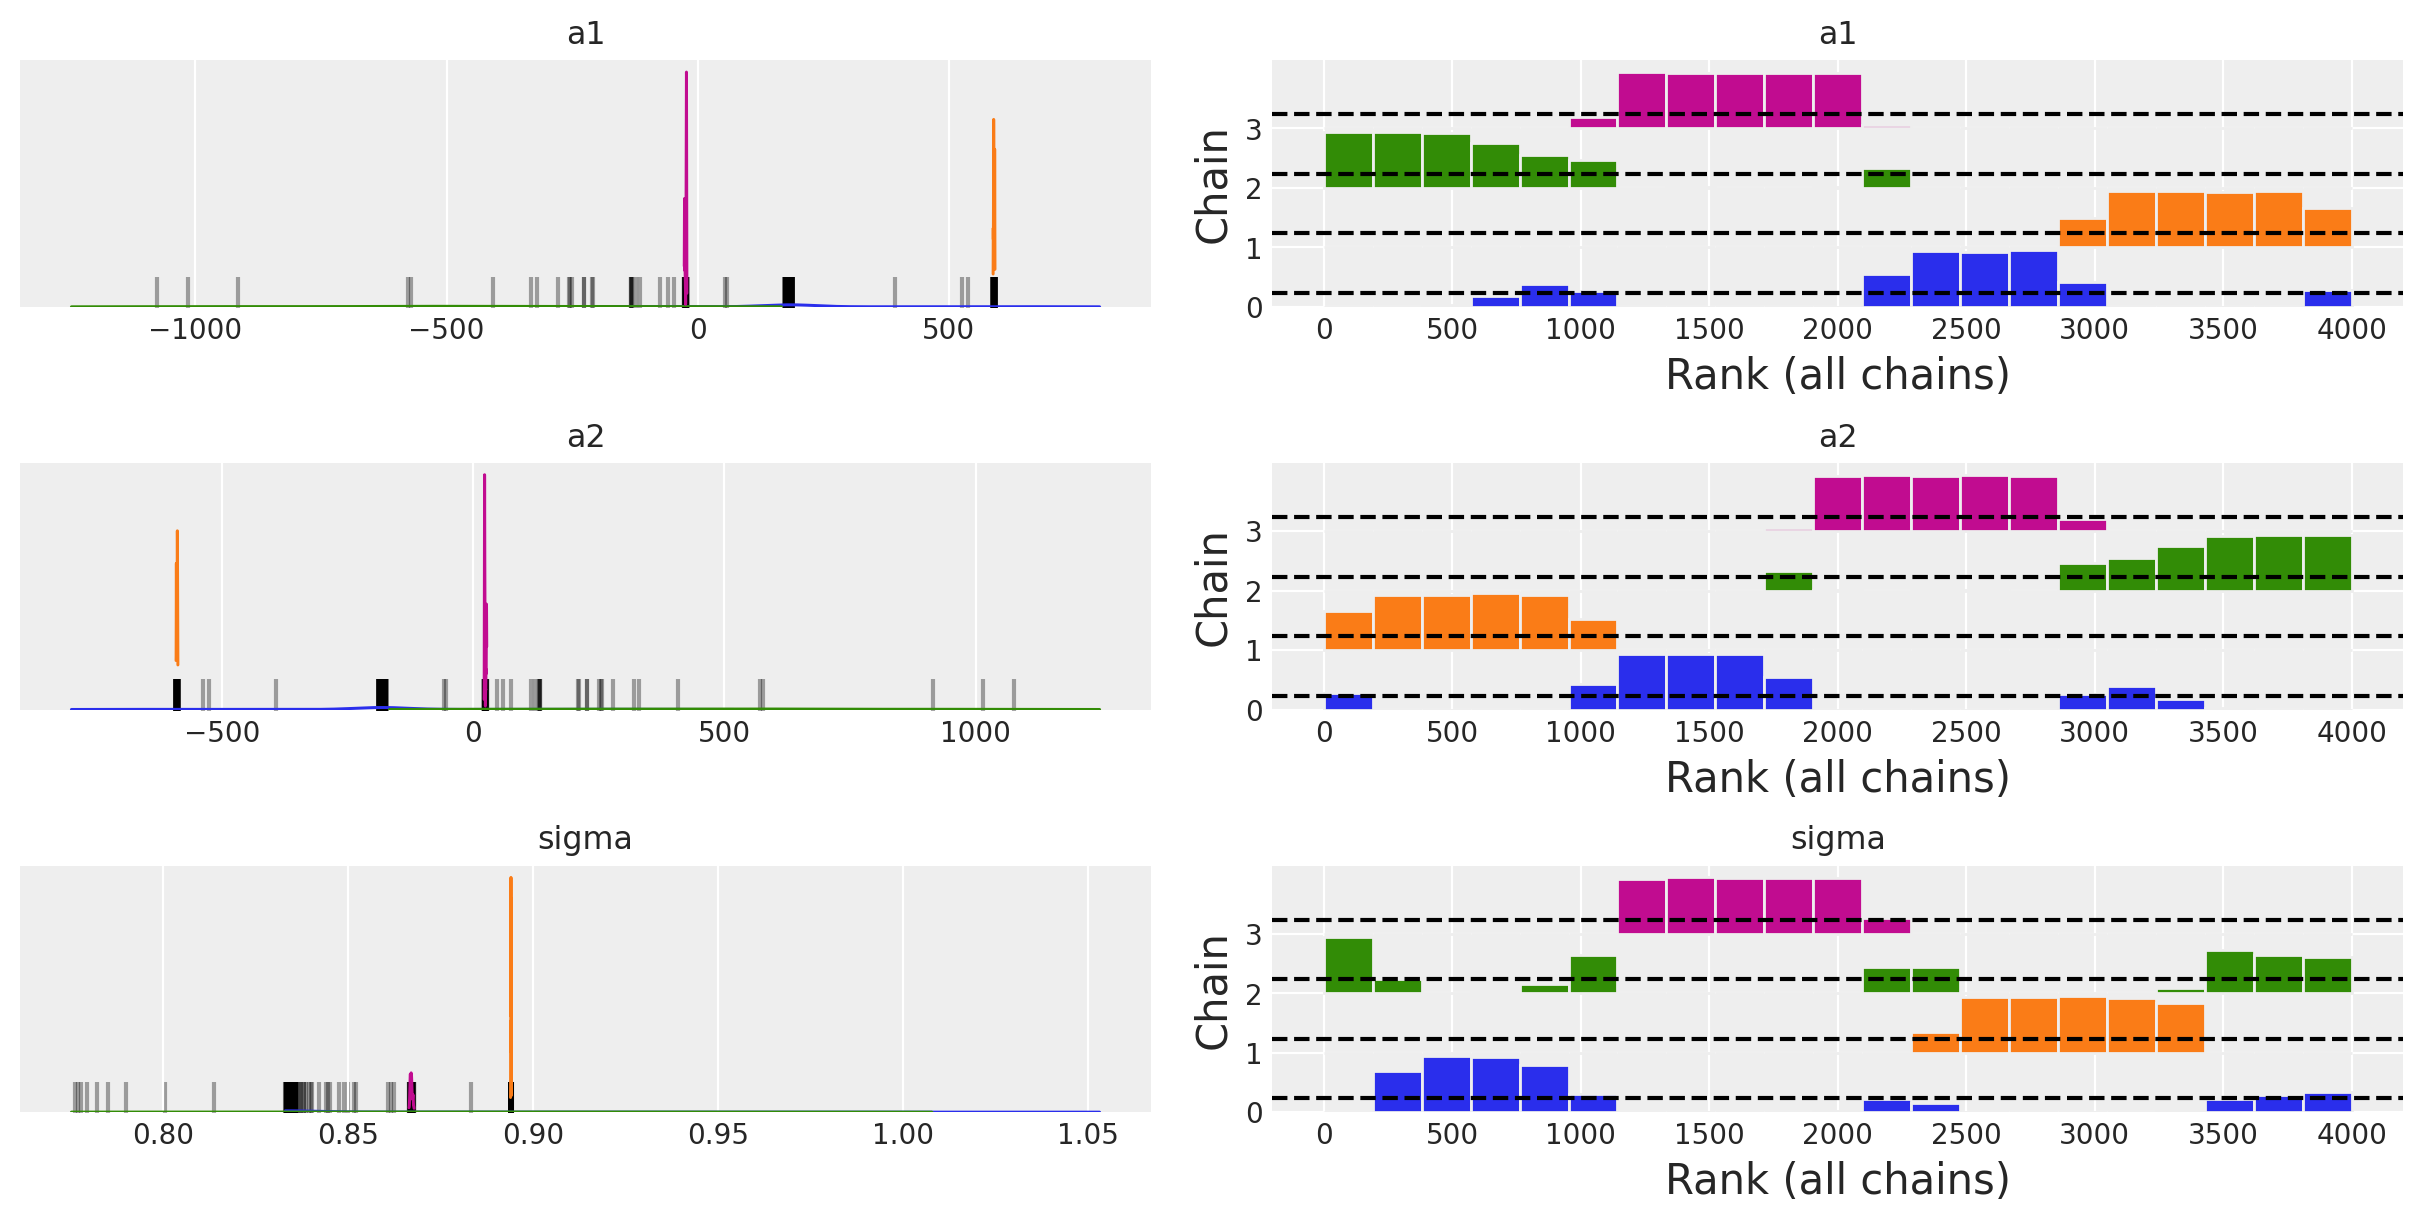

In [34]:
az.plot_trace(m9_4_trace, 
              var_names=(['a1','a2','sigma']),
              kind = 'rank_bars')
plt.show()

### Code 9.27

In [35]:
# define model: y ~ a1+a2
with pm.Model() as m9_5:
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a1+a2)
    y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    m9_5_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a2, a1]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:50<00:00, 158.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [36]:
# show model summary
varnames = ['~mu']
az.summary(m9_5_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
a1     0.05  7.47    -11.36      12.06
a2    -0.10  7.46    -12.06      11.37
sigma  0.89  0.06      0.78       0.98

In [37]:
az.ess(m9_5_trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    a1       float64 841.1
    a2       float64 841.6
    sigma    float64 1.67e+03
    mu       float64 3.646e+03

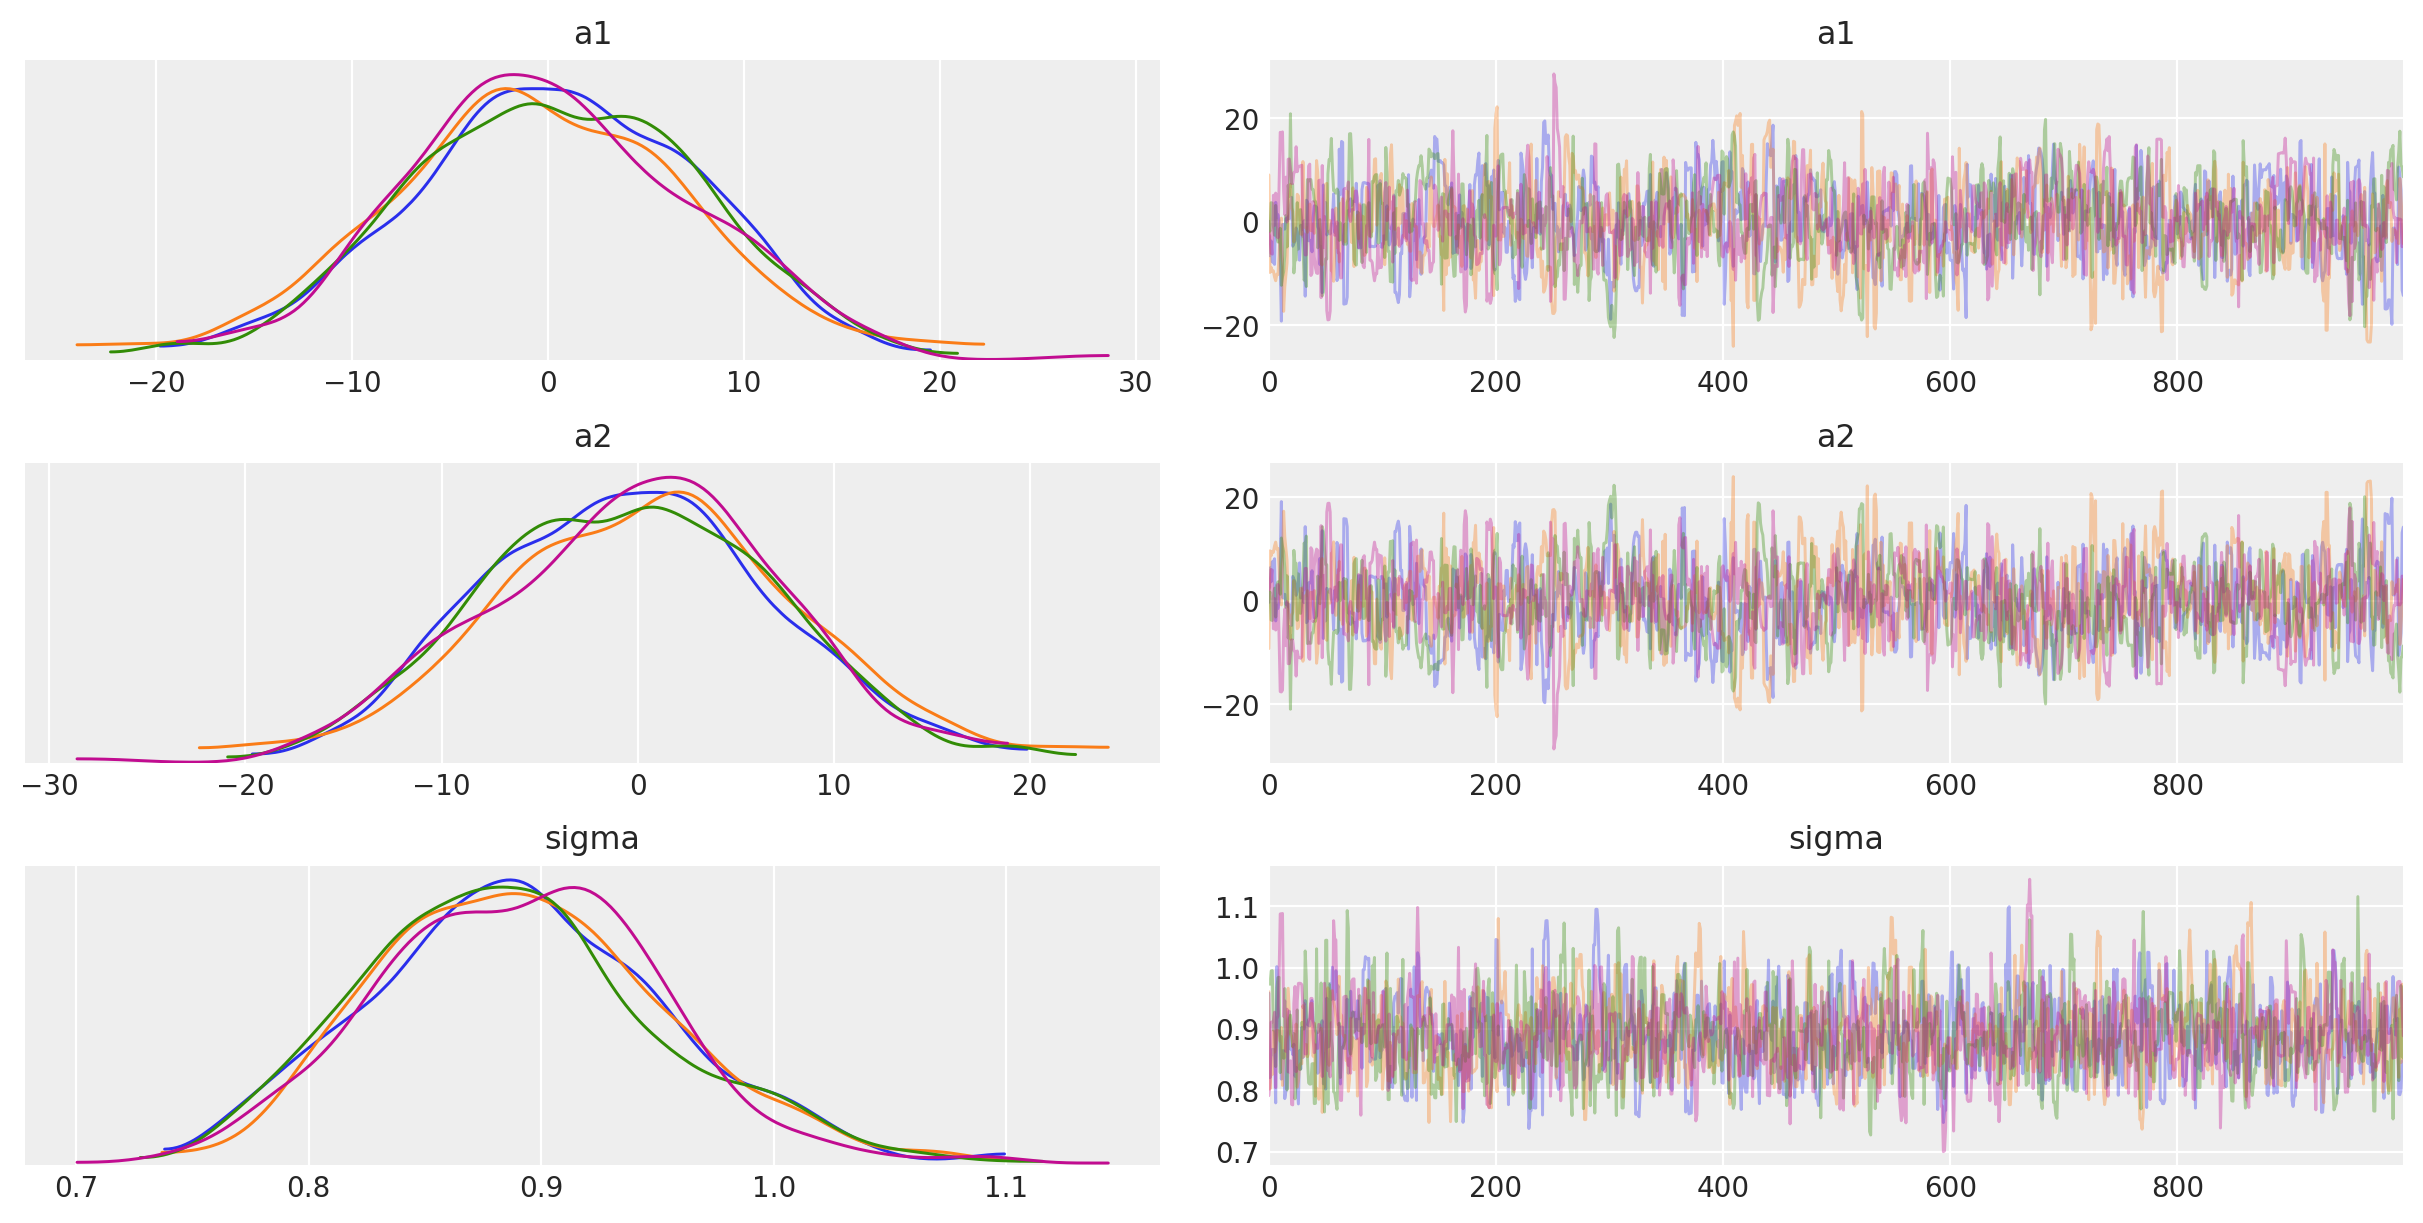

In [38]:
az.plot_trace(m9_5_trace, 
              var_names=(['a1','a2','sigma']))
plt.show()

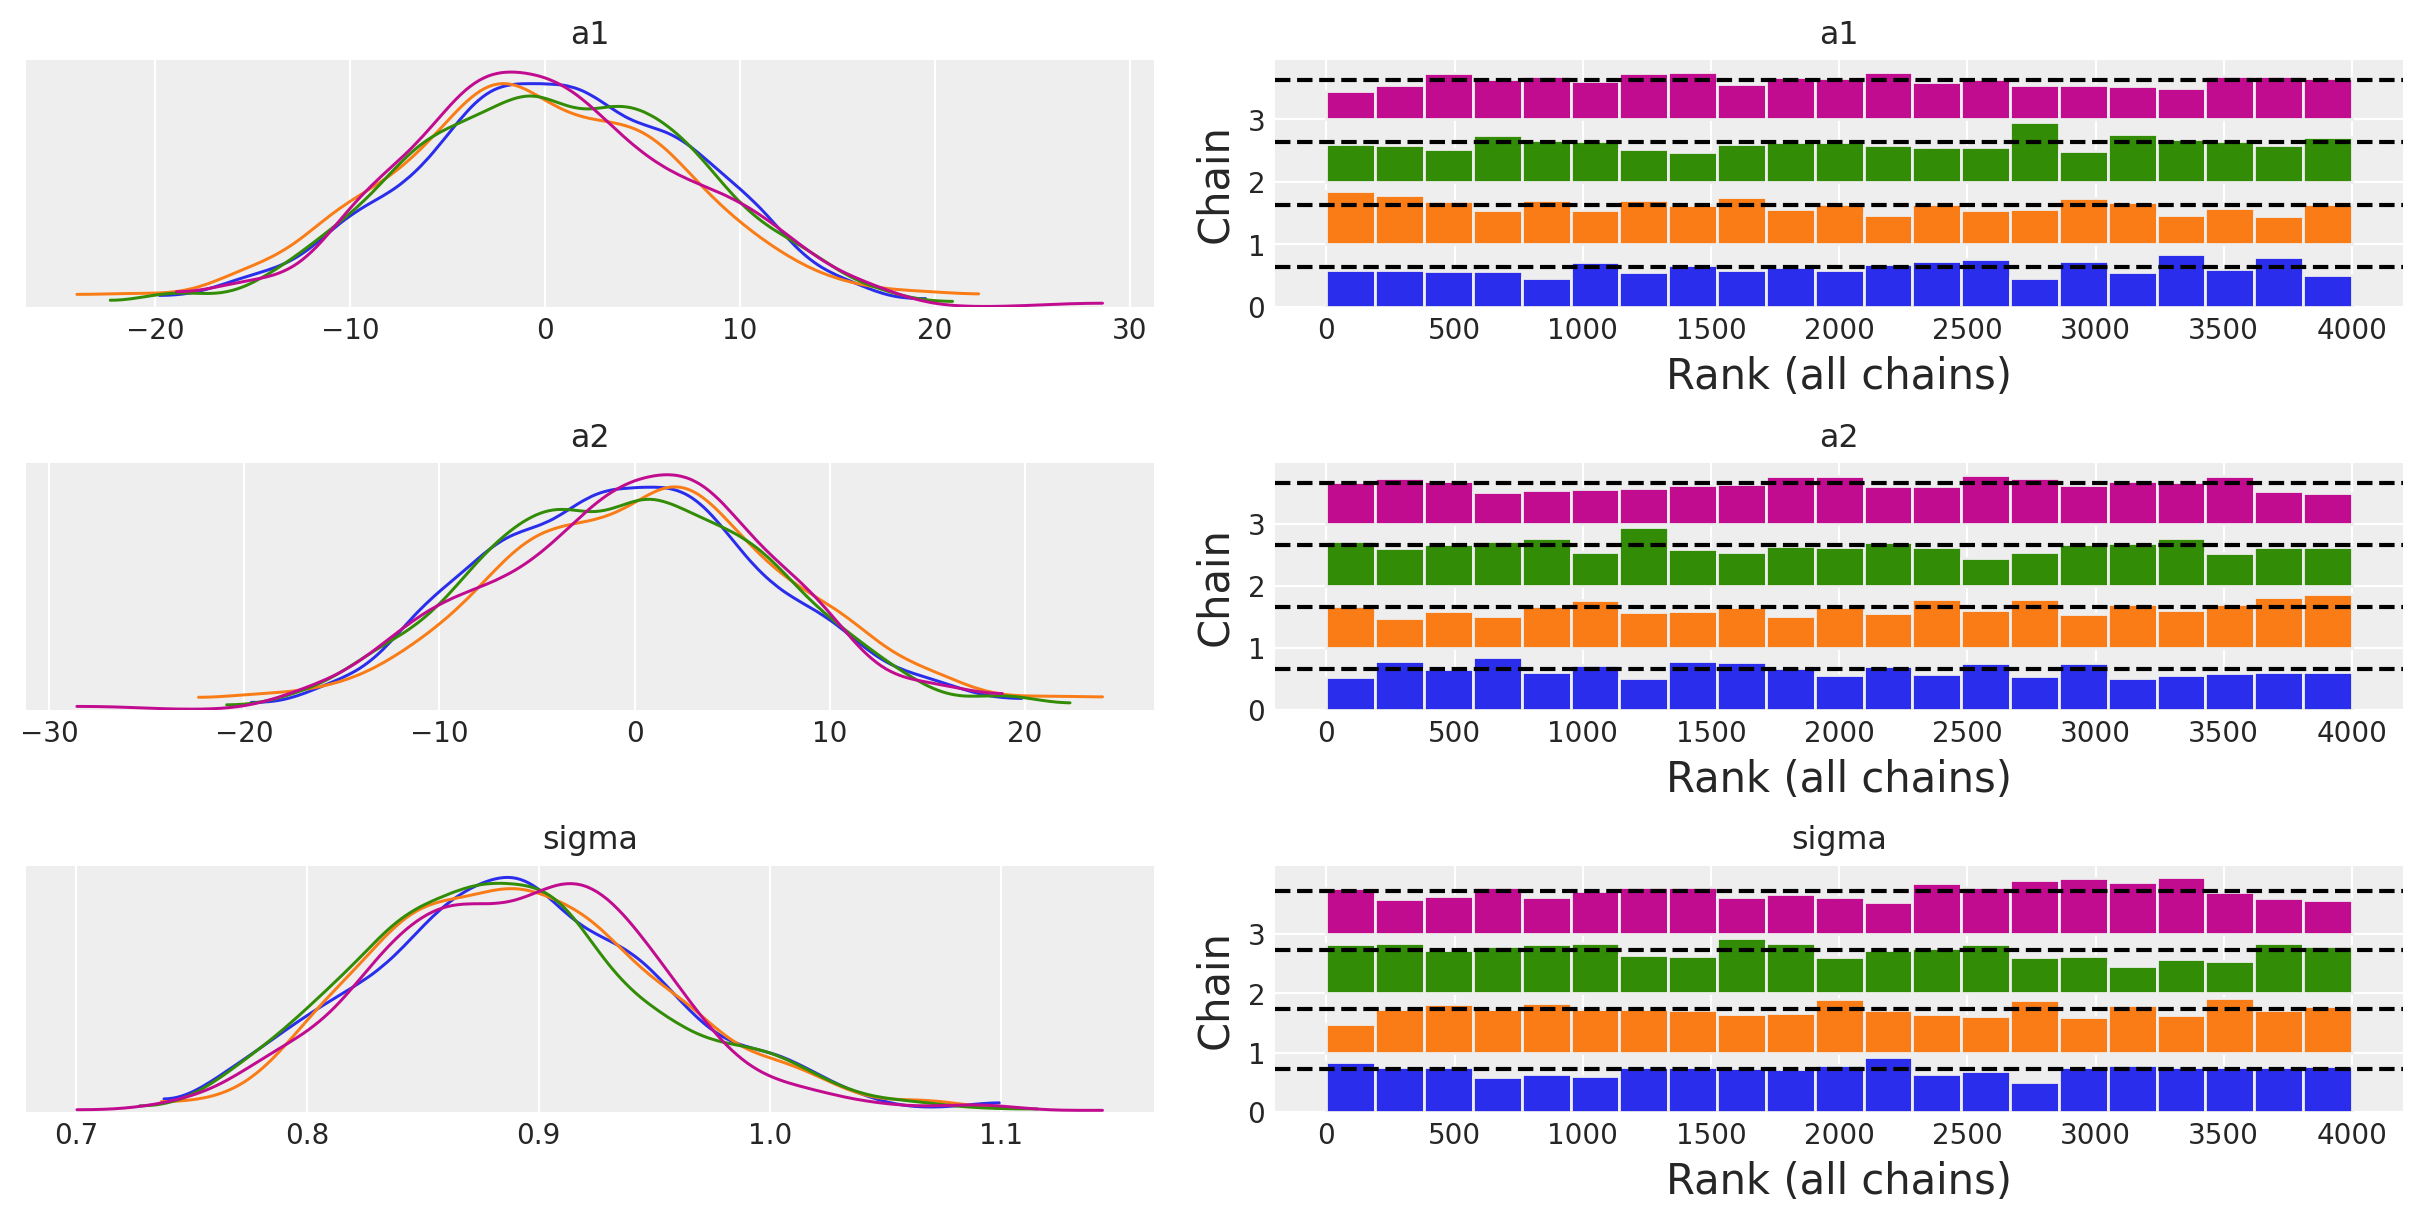

In [39]:
az.plot_trace(m9_5_trace, 
              var_names=(['a1','a2','sigma']),
              kind = 'rank_bars')
plt.show()

adding weak priors can speed up sampling, because the Markov chain won’t feel that it has to run out to extreme values that you, but not your model, already know are highly implausible.

### Referece

[pymc-devs: Rethinking_1 Chp08](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_08.ipynbb)